<div style='font-size:200%;'>
    <a></a>
    <h1 style='color: green; font-weight: bold; font-family: Cascadia code;'>
        <center>Lung cancer prediction using Image-Segmentation, Equalization and Transfer learning</center>
    </h1>
</div>

- - -

<!-- <div style='font-size:200%;'>
    <a id='nan'></a>
    <h1 style='color: chartreuse; font-weight: bold; font-family: Cascadia code;'> Contents </h1>
</div> -->

<!-- - [Importing the necessary libraries ](#import)
- [Data Pre-processing](#preprocess)
- [Exploratory Data Analysis](#eda)
    - [NaN values heat-map](#heatmap)
    - [Typecasting and dropping columns](#typecast)
    - [Correlation between different features and our target variable](#corr)
    - [Distribution of Individuals based on HomePlanet](#planet)
- [Distribution of transported individuals](#trans)
- [Data Pre-processing](#preprocess)
    - [Imputing missing data](#impute)
    - [Typecasting and dropping columns](#typecast)
    - [One-Hot Encoding](#ohe)
    - [Splitting data into x (Values) and y (labels)](#split)
- [Classifying](#classify)
    - [Building and fitting the models](#build)
    - [Performance Analysis of the different models](#anal)
- [Submission](#submit) -->

- - -

## **Abstract:**
 
The second leading cause of death is cancer [9]. From this large domain of cancer, lung cancer is one of the main reasons for death in the world among both men and women, with an impressive rate of about five million deadly cases per year. Every year more than 2,00,000 cases are found in US [11]. Because of high quantity data in CT images and blurred boundaries, tumor segmentation and classification is very hard. In MR images, the amount of data is too much for manual interpretation and analysis. At a very early stage, cancer is not being found because of the small size of the nodules and location of the glands [11]. 
 Machine Learning makes the diagnosis process easier and deterministic. This work has introduced one automatic lung cancer detection method to increase the accuracy and yield and decrease the diagnosis time. The main objective of this work is to detect the cancerous lung nodules from a given input lung image and to predict the lung cancer using Deep Learning technique more efficiently than the existings. 

- - -

<h1 ><a id='contents'><b>Contents<b></a></h1>

- [Importing necessary libraries](#import)
- [Proposed methodology](#methodology)
- [Data Pre-processing](#preprocess)
- [Comparison between processed and unprocessed image](#comparison)
- [Splitting the processed images](#split)
- [Neural nets](#nn)
    - [CNN](#cnn)
    - [VGG16](#vgg16)
    - [VGG19](#vgg19)
    - [MobileNet](#mobilenet)
    - [ResNet50](#resnet50)
    - [Xception](#xception)
    - [InceptionV3](#inceptionv3)
- [Example: Prediction vs Truth](#example)
- [Comparative analysis of the models](#analysis)
- [References](#references)

- - -

<div style='font-size:100%;'>
    <a id='import'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Importing the necessary libraries</center>
    </h1>
</div>

In [58]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders
import pandas as pd
import numpy as np
import seaborn as sns

<div style='font-size:100%;'>
    <a id='methodology'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Proposed Methodology</center>
    </h1>
</div>

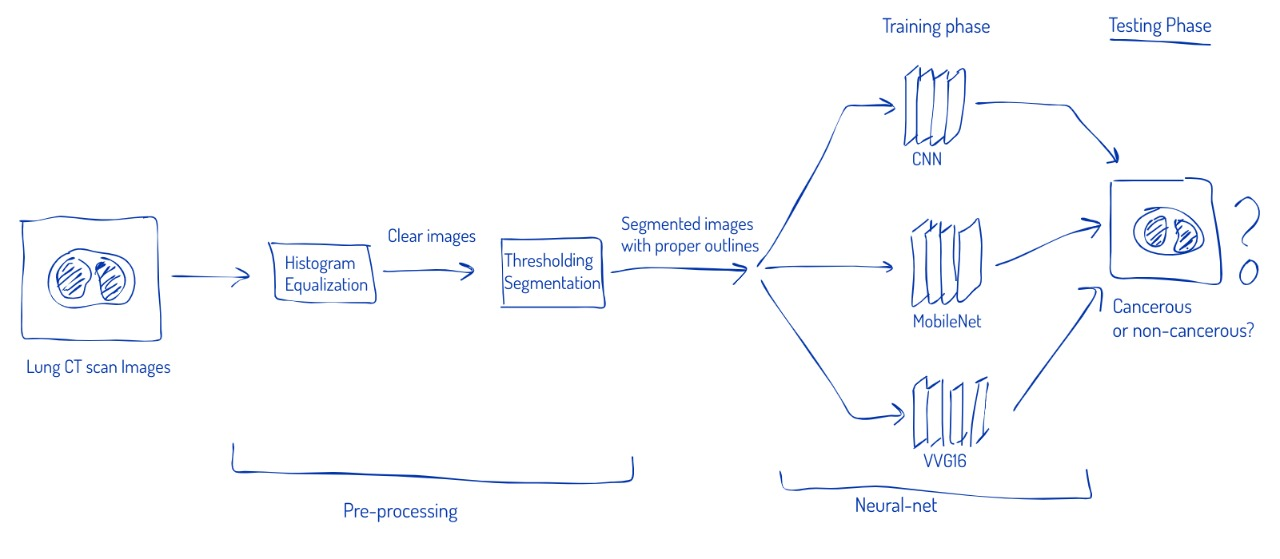

In [ ]:
Image(filename='./methodology.jpeg') 

<div style='font-size:100%;'>
    <a id='preprocess'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Data Pre-processing</center>
    </h1>
</div>

## **Histogram Equalization**

Histogram Equalization is a computer image processing technique used to improve contrast in images. It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image. This method usually increases the global contrast of images when its usable data is represented by close contrast values. This allows for areas of lower local contrast to gain a higher contrast.

## **Threshold Segmentation**

Thresholding is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze. In thresholding, we convert an image from colour or grayscale into a binary image, i.e., one that is simply black and white. Most frequently, we use thresholding as a way to select areas of interest of an image, while ignoring the parts we are not concerned with.

#### ***We will preprocess our raw data by histogram equalization and then segment it using thresholding***

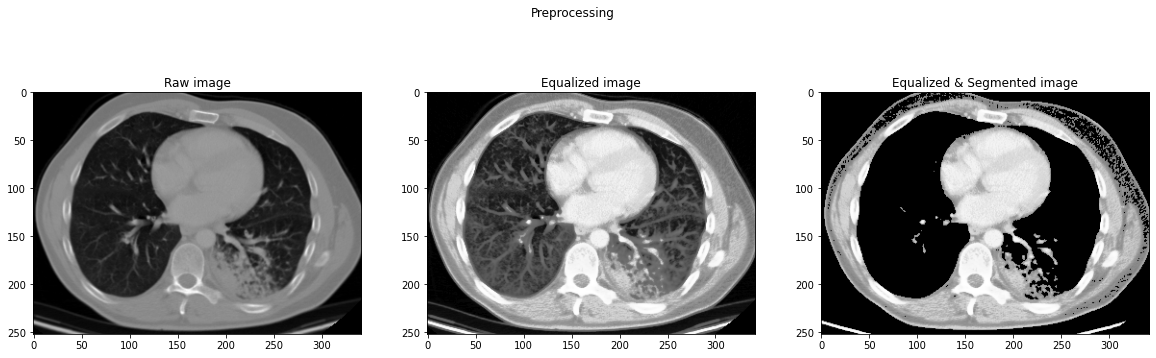

In [ ]:
img = cv2.imread('./rawData/squamous.cell.carcinoma/image1.png', 0)
equalizedImage = cv2.equalizeHist(img)
e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Raw image')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(equalizedImage, cv2.COLOR_BGR2RGB))
ax2.set_title('Equalized image')

ax3 = plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
ax3.set_title('Equalized & Segmented image')

plt.suptitle('Preprocessing')

plt.show()

In [ ]:
print(os.getcwd(), os.listdir())
DIR = './rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

/content ['.config', 'drive', 'MOBILENET.png', 'data', 'CNN.png', 'processedData', 'rawData', 'VGG16.png', 'sample_data']


In [ ]:
!unzip /content/drive/MyDrive/rawData.zip -d /content

In [ ]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('rawData/normal', 'data/non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('rawData/adenocarcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/large.cell.carcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/squamous.cell.carcinoma', 'data/cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at ./data


<div style='font-size:100%;'>
    <a id='comparison'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Comparison between processed and unprocessed image</center>
    </h1>
</div>

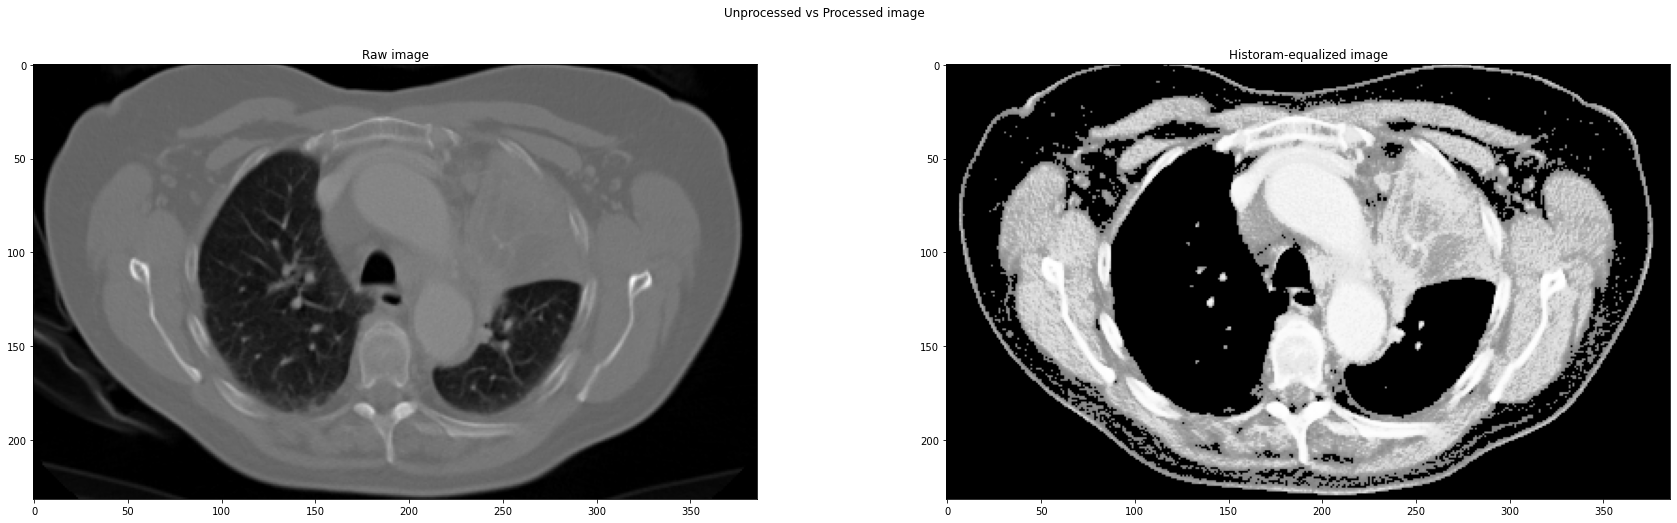

In [ ]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

<div style='font-size:100%;'>
    <a id='split'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [ ]:
FINAL_DIR = './processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2)) 

Copying files: 553 files [00:00, 4781.60 files/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BATCH_SIZE=32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/processedData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/processedData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/processedData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


<div style='font-size:100%;'>
    <a id='nn'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Neural nets</center>
    </h1>
</div>

In [7]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

def plot_history(hist, name):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].plot(hist.history['Accuracy'])
  axs[0].plot(hist.history['val_Accuracy'])
  axs[0].set_title(f'{name} Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'val', 'F1', 'Recall'], loc='upper left')

  axs[1].plot(hist.history['loss'])
  axs[1].plot(hist.history['val_loss'])
  axs[1].set_title(f'{name} Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'val'], loc='upper left')

  axs[2].plot(hist.history['Precision'])
  axs[2].plot(hist.history['val_Precision'])
  axs[2].set_title(f'{name} Precision')
  axs[2].set_ylabel('Precision')
  axs[2].set_xlabel('Epoch')
  axs[2].legend(['train', 'val'], loc='upper left')

  plt.show()


<h1 align="center" ><a id='cnn'><b>CNN<b></a></h1>

In [8]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

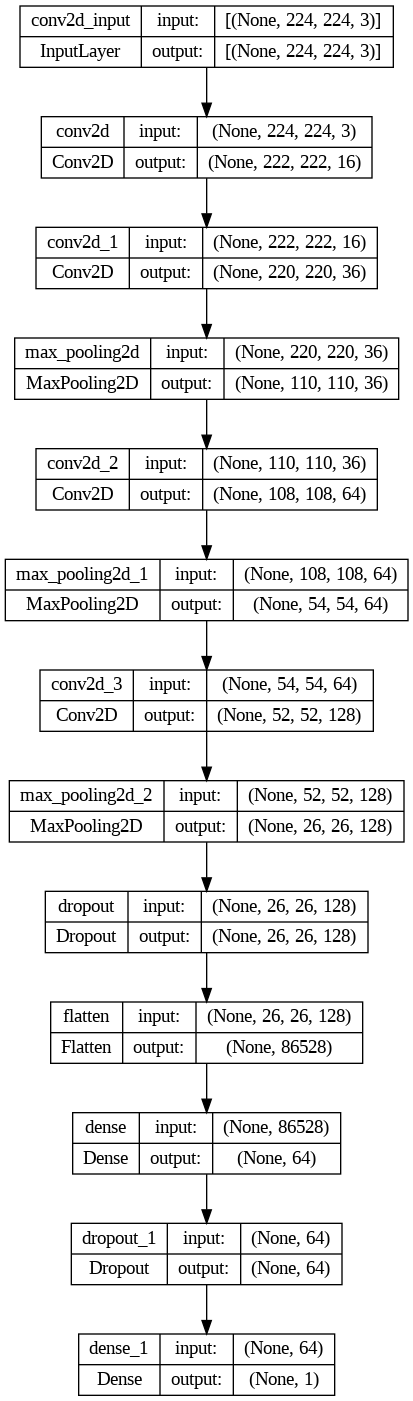

In [9]:
tf.keras.utils.plot_model(CNN, to_file='CNN.png', show_shapes=True,show_layer_names=True)
Image(filename='CNN.png')

In [9]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN_history = CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6843 - Accuracy: 0.7711 - Precision: 0.2500 - Recall: 0.0333 - AUC: 0.5478 - F1: 0.0249

22/22 [==============================] - 23s 723ms/step - loss: 0.6843 - Accuracy: 0.7711 - Precision: 0.2500 - Recall: 0.0333 - AUC: 0.5478 - F1: 0.0249 - val_loss: 0.4747 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8025 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4768 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6968 - F1: 0.0000e+00

22/22 [==============================] - 13s 571ms/step - loss: 0.4768 - Accuracy: 0.7854 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - AUC: 0.6968 - F1: 0.0000e+00 - val_loss: 0.3720 - val_Accuracy: 0.8586 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_AUC: 0.8397 - val_F1: 0.3745 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4459 - Accuracy: 0.7897 - Precision: 0.5714 - Recall: 0.0800 - AUC: 0.7665 - F1: 0.1133

22/22 [==============================] - 13s 569ms/step - loss: 0.4459 - Accuracy: 0.7897 - Precision: 0.5714 - Recall: 0.0800 - AUC: 0.7665 - F1: 0.1133 - val_loss: 0.3578 - val_Accuracy: 0.9091 - val_Precision: 1.0000 - val_Recall: 0.5714 - val_AUC: 0.8553 - val_F1: 0.7679 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4180 - Accuracy: 0.8126 - Precision: 0.6301 - Recall: 0.3067 - AUC: 0.8011 - F1: 0.3824

22/22 [==============================] - 13s 577ms/step - loss: 0.4180 - Accuracy: 0.8126 - Precision: 0.6301 - Recall: 0.3067 - AUC: 0.8011 - F1: 0.3824 - val_loss: 0.4970 - val_Accuracy: 0.7677 - val_Precision: 0.4773 - val_Recall: 1.0000 - val_AUC: 0.9261 - val_F1: 0.4821 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4250 - Accuracy: 0.8040 - Precision: 0.5970 - Recall: 0.2667 - AUC: 0.7938 - F1: 0.2915

22/22 [==============================] - 13s 571ms/step - loss: 0.4250 - Accuracy: 0.8040 - Precision: 0.5970 - Recall: 0.2667 - AUC: 0.7938 - F1: 0.2915 - val_loss: 0.3069 - val_Accuracy: 0.9192 - val_Precision: 0.9333 - val_Recall: 0.6667 - val_AUC: 0.9344 - val_F1: 0.7819 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3506 - Accuracy: 0.8498 - Precision: 0.7586 - Recall: 0.4400 - AUC: 0.8645 - F1: 0.4922

22/22 [==============================] - 12s 534ms/step - loss: 0.3506 - Accuracy: 0.8498 - Precision: 0.7586 - Recall: 0.4400 - AUC: 0.8645 - F1: 0.4922 - val_loss: 0.2233 - val_Accuracy: 0.8990 - val_Precision: 1.0000 - val_Recall: 0.5238 - val_AUC: 0.9860 - val_F1: 0.7681 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3313 - Accuracy: 0.8512 - Precision: 0.7500 - Recall: 0.4600 - AUC: 0.8878 - F1: 0.5314

22/22 [==============================] - 13s 566ms/step - loss: 0.3313 - Accuracy: 0.8512 - Precision: 0.7500 - Recall: 0.4600 - AUC: 0.8878 - F1: 0.5314 - val_loss: 0.2150 - val_Accuracy: 0.9293 - val_Precision: 0.9375 - val_Recall: 0.7143 - val_AUC: 0.9734 - val_F1: 0.6099 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2939 - Accuracy: 0.8856 - Precision: 0.8500 - Recall: 0.5667 - AUC: 0.9138 - F1: 0.6712

22/22 [==============================] - 13s 568ms/step - loss: 0.2939 - Accuracy: 0.8856 - Precision: 0.8500 - Recall: 0.5667 - AUC: 0.9138 - F1: 0.6712 - val_loss: 0.1614 - val_Accuracy: 0.9394 - val_Precision: 1.0000 - val_Recall: 0.7143 - val_AUC: 0.9844 - val_F1: 0.6035 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2771 - Accuracy: 0.8856 - Precision: 0.8241 - Recall: 0.5933 - AUC: 0.9247 - F1: 0.6768

22/22 [==============================] - 12s 561ms/step - loss: 0.2771 - Accuracy: 0.8856 - Precision: 0.8241 - Recall: 0.5933 - AUC: 0.9247 - F1: 0.6768 - val_loss: 0.4763 - val_Accuracy: 0.7172 - val_Precision: 0.4286 - val_Recall: 1.0000 - val_AUC: 0.9823 - val_F1: 0.6123 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.3070 - Accuracy: 0.8684 - Precision: 0.7589 - Recall: 0.5667 - AUC: 0.9061 - F1: 0.6307

22/22 [==============================] - 12s 565ms/step - loss: 0.3070 - Accuracy: 0.8684 - Precision: 0.7589 - Recall: 0.5667 - AUC: 0.9061 - F1: 0.6307 - val_loss: 0.1853 - val_Accuracy: 0.9192 - val_Precision: 1.0000 - val_Recall: 0.6190 - val_AUC: 0.9908 - val_F1: 0.5750 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2583 - Accuracy: 0.8827 - Precision: 0.8036 - Recall: 0.6000 - AUC: 0.9387 - F1: 0.6842
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 553ms/step - loss: 0.2583 - Accuracy: 0.8827 - Precision: 0.8036 - Recall: 0.6000 - AUC: 0.9387 - F1: 0.6842 - val_loss: 0.2522 - val_Accuracy: 0.8788 - val_Precision: 0.6364 - val_Recall: 1.0000 - val_AUC: 0.9939 - val_F1: 0.5855 - lr: 0.0010
Epoch 11: early stopping


In [10]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 167ms/step - loss: 0.2281 - Accuracy: 0.9109 - Precision: 0.7167 - Recall: 0.9773 - AUC: 0.9841 - F1: 0.8377


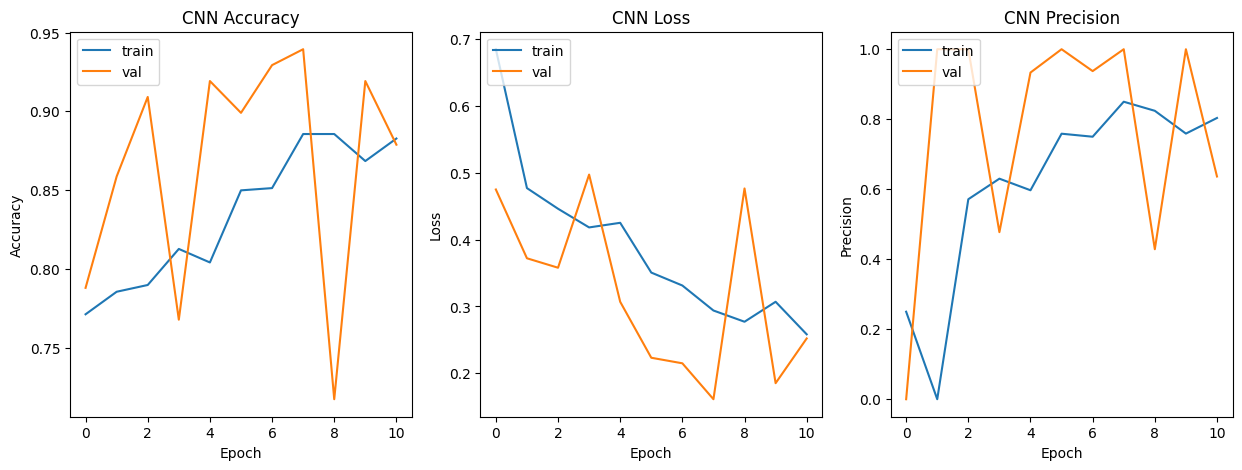

In [11]:
plot_history(CNN_history, 'CNN')

<h1 align="center" ><a id='vgg16'><b>VGG16<b></a></h1>

In [12]:
VGG16_base = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16=tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG16.summary()

VGG16.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

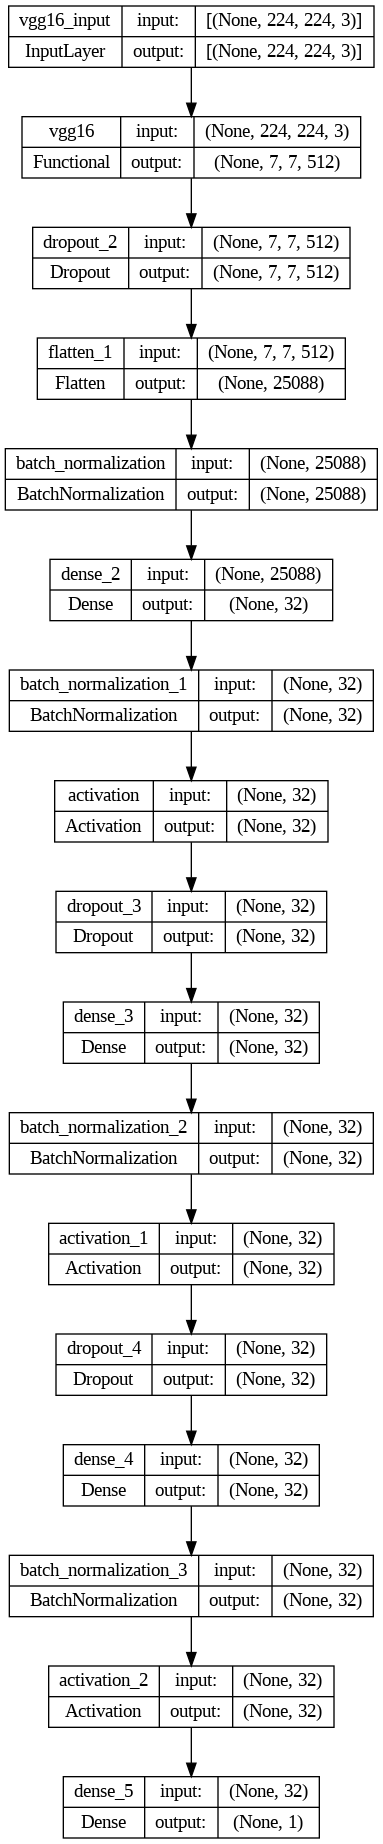

In [14]:
tf.keras.utils.plot_model(VGG16, to_file='VGG16.png', show_shapes=True,show_layer_names=True)
Image(filename='VGG16.png')

In [13]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16_history = VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 36, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5254 - Accuracy: 0.7847 - Precision: 0.5000 - Recall: 0.3093 - AUC: 0.7401 - F1: 0.1492

22/22 [==============================] - 27s 801ms/step - loss: 0.5254 - Accuracy: 0.7847 - Precision: 0.5000 - Recall: 0.3093 - AUC: 0.7401 - F1: 0.1492 - val_loss: 0.8079 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8193 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4778 - Accuracy: 0.7883 - Precision: 0.5278 - Recall: 0.1267 - AUC: 0.7174 - F1: 0.1919

22/22 [==============================] - 13s 574ms/step - loss: 0.4778 - Accuracy: 0.7883 - Precision: 0.5278 - Recall: 0.1267 - AUC: 0.7174 - F1: 0.1919 - val_loss: 0.5394 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8980 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4527 - Accuracy: 0.7883 - Precision: 0.5217 - Recall: 0.1600 - AUC: 0.7605 - F1: 0.2377

22/22 [==============================] - 13s 578ms/step - loss: 0.4527 - Accuracy: 0.7883 - Precision: 0.5217 - Recall: 0.1600 - AUC: 0.7605 - F1: 0.2377 - val_loss: 0.3693 - val_Accuracy: 0.8283 - val_Precision: 1.0000 - val_Recall: 0.1905 - val_AUC: 0.9496 - val_F1: 0.2431 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4098 - Accuracy: 0.8040 - Precision: 0.7097 - Recall: 0.1467 - AUC: 0.8278 - F1: 0.2240

22/22 [==============================] - 13s 575ms/step - loss: 0.4098 - Accuracy: 0.8040 - Precision: 0.7097 - Recall: 0.1467 - AUC: 0.8278 - F1: 0.2240 - val_loss: 0.3899 - val_Accuracy: 0.7980 - val_Precision: 1.0000 - val_Recall: 0.0476 - val_AUC: 0.9728 - val_F1: 0.1000 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4143 - Accuracy: 0.8011 - Precision: 0.6667 - Recall: 0.1467 - AUC: 0.8188 - F1: 0.2245

22/22 [==============================] - 13s 575ms/step - loss: 0.4143 - Accuracy: 0.8011 - Precision: 0.6667 - Recall: 0.1467 - AUC: 0.8188 - F1: 0.2245 - val_loss: 0.3562 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_AUC: 0.9744 - val_F1: 0.3214 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3802 - Accuracy: 0.8069 - Precision: 0.6829 - Recall: 0.1867 - AUC: 0.8551 - F1: 0.2808

22/22 [==============================] - 13s 587ms/step - loss: 0.3802 - Accuracy: 0.8069 - Precision: 0.6829 - Recall: 0.1867 - AUC: 0.8551 - F1: 0.2808 - val_loss: 0.2523 - val_Accuracy: 0.8384 - val_Precision: 1.0000 - val_Recall: 0.2381 - val_AUC: 0.9979 - val_F1: 0.2111 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3542 - Accuracy: 0.8326 - Precision: 0.7705 - Recall: 0.3133 - AUC: 0.8824 - F1: 0.4431

22/22 [==============================] - 13s 580ms/step - loss: 0.3542 - Accuracy: 0.8326 - Precision: 0.7705 - Recall: 0.3133 - AUC: 0.8824 - F1: 0.4431 - val_loss: 0.2045 - val_Accuracy: 0.8788 - val_Precision: 1.0000 - val_Recall: 0.4286 - val_AUC: 0.9951 - val_F1: 0.4120 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.3199 - Accuracy: 0.8512 - Precision: 0.7805 - Recall: 0.4267 - AUC: 0.9195 - F1: 0.5383

22/22 [==============================] - 13s 574ms/step - loss: 0.3199 - Accuracy: 0.8512 - Precision: 0.7805 - Recall: 0.4267 - AUC: 0.9195 - F1: 0.5383 - val_loss: 0.1860 - val_Accuracy: 0.8889 - val_Precision: 1.0000 - val_Recall: 0.4762 - val_AUC: 0.9963 - val_F1: 0.7111 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.3025 - Accuracy: 0.8755 - Precision: 0.8119 - Recall: 0.5467 - AUC: 0.9252 - F1: 0.6148

22/22 [==============================] - 13s 580ms/step - loss: 0.3025 - Accuracy: 0.8755 - Precision: 0.8119 - Recall: 0.5467 - AUC: 0.9252 - F1: 0.6148 - val_loss: 0.1710 - val_Accuracy: 0.9091 - val_Precision: 1.0000 - val_Recall: 0.5714 - val_AUC: 0.9982 - val_F1: 0.5526 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.3016 - Accuracy: 0.8612 - Precision: 0.7431 - Recall: 0.5400 - AUC: 0.9227 - F1: 0.5869

22/22 [==============================] - 13s 582ms/step - loss: 0.3016 - Accuracy: 0.8612 - Precision: 0.7431 - Recall: 0.5400 - AUC: 0.9227 - F1: 0.5869 - val_loss: 0.1434 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9963 - val_F1: 0.7106 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2871 - Accuracy: 0.8770 - Precision: 0.7963 - Recall: 0.5733 - AUC: 0.9293 - F1: 0.6217

22/22 [==============================] - 13s 573ms/step - loss: 0.2871 - Accuracy: 0.8770 - Precision: 0.7963 - Recall: 0.5733 - AUC: 0.9293 - F1: 0.6217 - val_loss: 0.1293 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9982 - val_F1: 0.7333 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2971 - Accuracy: 0.8813 - Precision: 0.7638 - Recall: 0.6467 - AUC: 0.9172 - F1: 0.6995

22/22 [==============================] - 13s 589ms/step - loss: 0.2971 - Accuracy: 0.8813 - Precision: 0.7638 - Recall: 0.6467 - AUC: 0.9172 - F1: 0.6995 - val_loss: 0.1316 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9973 - val_F1: 0.7308 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2603 - Accuracy: 0.8956 - Precision: 0.7895 - Recall: 0.7000 - AUC: 0.9429 - F1: 0.7385

22/22 [==============================] - 13s 579ms/step - loss: 0.2603 - Accuracy: 0.8956 - Precision: 0.7895 - Recall: 0.7000 - AUC: 0.9429 - F1: 0.7385 - val_loss: 0.1246 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9982 - val_F1: 0.7308 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.2574 - Accuracy: 0.8970 - Precision: 0.8095 - Recall: 0.6800 - AUC: 0.9448 - F1: 0.7174

22/22 [==============================] - 13s 577ms/step - loss: 0.2574 - Accuracy: 0.8970 - Precision: 0.8095 - Recall: 0.6800 - AUC: 0.9448 - F1: 0.7174 - val_loss: 0.1095 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9982 - val_F1: 0.9853 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.2377 - Accuracy: 0.9113 - Precision: 0.8284 - Recall: 0.7400 - AUC: 0.9554 - F1: 0.7781

22/22 [==============================] - 13s 579ms/step - loss: 0.2377 - Accuracy: 0.9113 - Precision: 0.8284 - Recall: 0.7400 - AUC: 0.9554 - F1: 0.7781 - val_loss: 0.0919 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9994 - val_F1: 0.7353 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.2336 - Accuracy: 0.9056 - Precision: 0.7800 - Recall: 0.7800 - AUC: 0.9509 - F1: 0.7616

22/22 [==============================] - 13s 581ms/step - loss: 0.2336 - Accuracy: 0.9056 - Precision: 0.7800 - Recall: 0.7800 - AUC: 0.9509 - F1: 0.7616 - val_loss: 0.0865 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9991 - val_F1: 0.7308 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.2060 - Accuracy: 0.9170 - Precision: 0.8151 - Recall: 0.7933 - AUC: 0.9678 - F1: 0.7868

22/22 [==============================] - 13s 574ms/step - loss: 0.2060 - Accuracy: 0.9170 - Precision: 0.8151 - Recall: 0.7933 - AUC: 0.9678 - F1: 0.7868 - val_loss: 0.0879 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9982 - val_F1: 0.7141 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.2395 - Accuracy: 0.9056 - Precision: 0.7958 - Recall: 0.7533 - AUC: 0.9487 - F1: 0.7687

22/22 [==============================] - 13s 579ms/step - loss: 0.2395 - Accuracy: 0.9056 - Precision: 0.7958 - Recall: 0.7533 - AUC: 0.9487 - F1: 0.7687 - val_loss: 0.0829 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9988 - val_F1: 0.7154 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.2161 - Accuracy: 0.9170 - Precision: 0.8194 - Recall: 0.7867 - AUC: 0.9563 - F1: 0.7961

22/22 [==============================] - 13s 575ms/step - loss: 0.2161 - Accuracy: 0.9170 - Precision: 0.8194 - Recall: 0.7867 - AUC: 0.9563 - F1: 0.7961 - val_loss: 0.0821 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9982 - val_F1: 0.9641 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.2135 - Accuracy: 0.8970 - Precision: 0.7786 - Recall: 0.7267 - AUC: 0.9605 - F1: 0.7497

22/22 [==============================] - 12s 562ms/step - loss: 0.2135 - Accuracy: 0.8970 - Precision: 0.7786 - Recall: 0.7267 - AUC: 0.9605 - F1: 0.7497 - val_loss: 0.0760 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9969 - val_F1: 0.7273 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.2000 - Accuracy: 0.9170 - Precision: 0.8067 - Recall: 0.8067 - AUC: 0.9650 - F1: 0.7792

22/22 [==============================] - 13s 569ms/step - loss: 0.2000 - Accuracy: 0.9170 - Precision: 0.8067 - Recall: 0.8067 - AUC: 0.9650 - F1: 0.7792 - val_loss: 0.0662 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9982 - val_F1: 0.7273 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.2236 - Accuracy: 0.9113 - Precision: 0.8014 - Recall: 0.7800 - AUC: 0.9542 - F1: 0.7843

22/22 [==============================] - 13s 578ms/step - loss: 0.2236 - Accuracy: 0.9113 - Precision: 0.8014 - Recall: 0.7800 - AUC: 0.9542 - F1: 0.7843 - val_loss: 0.0680 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 1.0000 - val_F1: 0.7308 - lr: 0.0010
Epoch 23/36
22/22 [==============================] - ETA: 0s - loss: 0.1730 - Accuracy: 0.9270 - Precision: 0.8462 - Recall: 0.8067 - AUC: 0.9743 - F1: 0.8153

22/22 [==============================] - 13s 576ms/step - loss: 0.1730 - Accuracy: 0.9270 - Precision: 0.8462 - Recall: 0.8067 - AUC: 0.9743 - F1: 0.8153 - val_loss: 0.0730 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9988 - val_F1: 0.7273 - lr: 0.0010
Epoch 24/36
22/22 [==============================] - ETA: 0s - loss: 0.2082 - Accuracy: 0.9213 - Precision: 0.8188 - Recall: 0.8133 - AUC: 0.9563 - F1: 0.8130
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 570ms/step - loss: 0.2082 - Accuracy: 0.9213 - Precision: 0.8188 - Recall: 0.8133 - AUC: 0.9563 - F1: 0.8130 - val_loss: 0.0698 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9991 - val_F1: 0.7222 - lr: 0.0010
Epoch 24: early stopping


In [14]:
VGG16_scores = VGG16.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 3s 412ms/step - loss: 0.0690 - Accuracy: 0.9901 - Precision: 0.9565 - Recall: 1.0000 - AUC: 0.9997 - F1: 0.9815


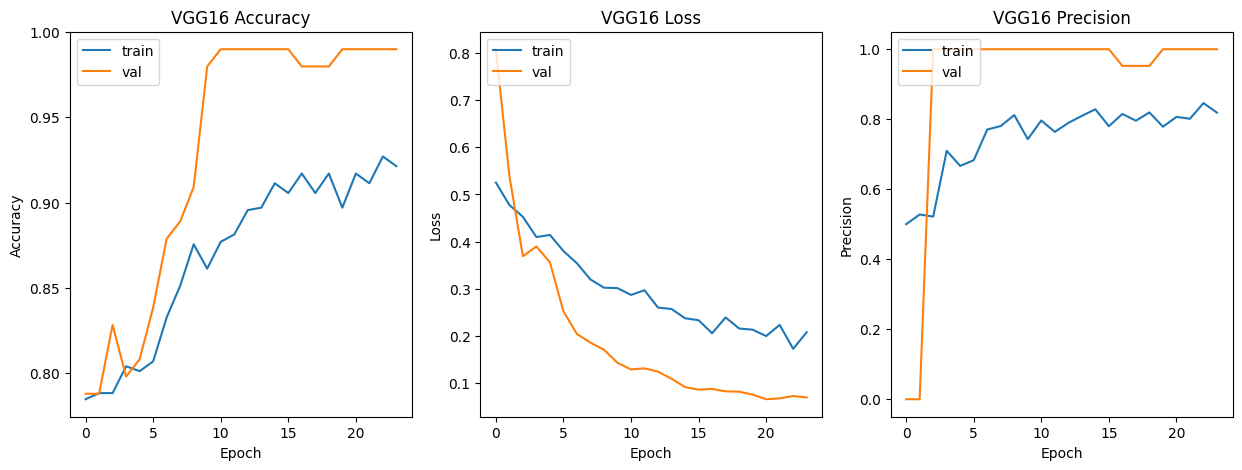

In [15]:
plot_history(VGG16_history, 'VGG16')

<h1 align="center" ><a id='mobilenet'><b>MobileNet<b></a></h1>

In [16]:
MOBILENET_base =  tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top= False)

for layer in MOBILENET_base.layers:
    layer.trainable = False

MOBILENET=tf.keras.Sequential()
MOBILENET.add(MOBILENET_base)
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Flatten())
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dense(1,activation='sigmoid'))

MOBILENET.summary()

MOBILENET.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 50176)            200704    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 32)                1605664   
                                                                 
 batch_normalization_5 (Batc  (None, 32)              

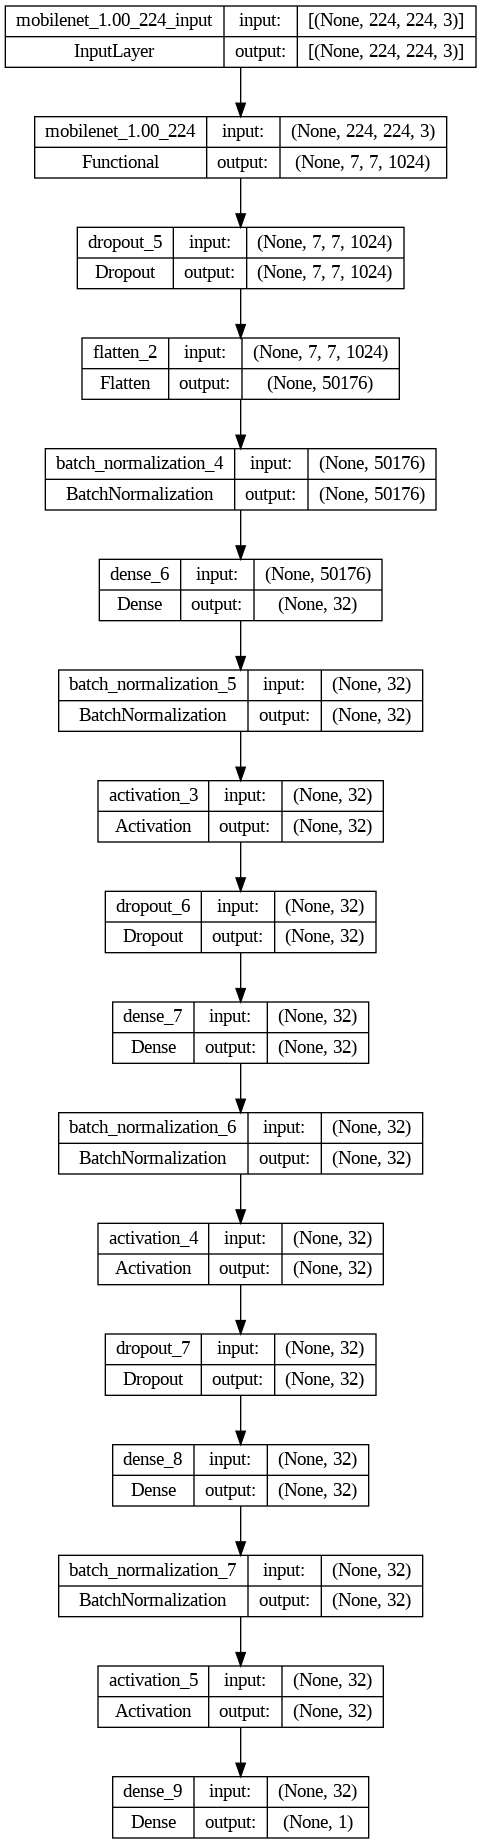

In [19]:
tf.keras.utils.plot_model(MOBILENET, to_file='MOBILENET.png', show_shapes=True,show_layer_names=True)
Image(filename='MOBILENET.png')

In [17]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('MOBILENET.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

MOBILENET_history = MOBILENET.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6418 - Accuracy: 0.7325 - Precision: 0.4239 - Recall: 0.6753 - AUC: 0.7992 - F1: 0.4262

22/22 [==============================] - 19s 597ms/step - loss: 0.6418 - Accuracy: 0.7325 - Precision: 0.4239 - Recall: 0.6753 - AUC: 0.7992 - F1: 0.4262 - val_loss: 3.4370 - val_Accuracy: 0.2121 - val_Precision: 0.2121 - val_Recall: 1.0000 - val_AUC: 0.8031 - val_F1: 0.2671 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4682 - Accuracy: 0.8255 - Precision: 0.5854 - Recall: 0.6400 - AUC: 0.8255 - F1: 0.6123

22/22 [==============================] - 12s 534ms/step - loss: 0.4682 - Accuracy: 0.8255 - Precision: 0.5854 - Recall: 0.6400 - AUC: 0.8255 - F1: 0.6123 - val_loss: 0.6010 - val_Accuracy: 0.6667 - val_Precision: 0.3889 - val_Recall: 1.0000 - val_AUC: 0.9567 - val_F1: 0.5353 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.3750 - Accuracy: 0.8741 - Precision: 0.7246 - Recall: 0.6667 - AUC: 0.8863 - F1: 0.6831

22/22 [==============================] - 12s 550ms/step - loss: 0.3750 - Accuracy: 0.8741 - Precision: 0.7246 - Recall: 0.6667 - AUC: 0.8863 - F1: 0.6831 - val_loss: 0.3712 - val_Accuracy: 0.8384 - val_Precision: 0.5676 - val_Recall: 1.0000 - val_AUC: 0.9844 - val_F1: 0.5000 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3416 - Accuracy: 0.8741 - Precision: 0.7672 - Recall: 0.5933 - AUC: 0.8988 - F1: 0.6701

22/22 [==============================] - 12s 545ms/step - loss: 0.3416 - Accuracy: 0.8741 - Precision: 0.7672 - Recall: 0.5933 - AUC: 0.8988 - F1: 0.6701 - val_loss: 0.3174 - val_Accuracy: 0.8485 - val_Precision: 0.5882 - val_Recall: 0.9524 - val_AUC: 0.9875 - val_F1: 0.7194 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3006 - Accuracy: 0.8898 - Precision: 0.7874 - Recall: 0.6667 - AUC: 0.9170 - F1: 0.7248

22/22 [==============================] - 12s 548ms/step - loss: 0.3006 - Accuracy: 0.8898 - Precision: 0.7874 - Recall: 0.6667 - AUC: 0.9170 - F1: 0.7248 - val_loss: 0.2548 - val_Accuracy: 0.9091 - val_Precision: 0.7143 - val_Recall: 0.9524 - val_AUC: 0.9820 - val_F1: 0.6195 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.2540 - Accuracy: 0.9142 - Precision: 0.8750 - Recall: 0.7000 - AUC: 0.9562 - F1: 0.7769

22/22 [==============================] - 11s 505ms/step - loss: 0.2540 - Accuracy: 0.9142 - Precision: 0.8750 - Recall: 0.7000 - AUC: 0.9562 - F1: 0.7769 - val_loss: 0.1702 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9878 - val_F1: 0.6797 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.2408 - Accuracy: 0.9227 - Precision: 0.8810 - Recall: 0.7400 - AUC: 0.9421 - F1: 0.8077

22/22 [==============================] - 14s 638ms/step - loss: 0.2408 - Accuracy: 0.9227 - Precision: 0.8810 - Recall: 0.7400 - AUC: 0.9421 - F1: 0.8077 - val_loss: 0.1224 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9844 - val_F1: 0.7143 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2103 - Accuracy: 0.9213 - Precision: 0.8626 - Recall: 0.7533 - AUC: 0.9659 - F1: 0.8059

22/22 [==============================] - 17s 698ms/step - loss: 0.2103 - Accuracy: 0.9213 - Precision: 0.8626 - Recall: 0.7533 - AUC: 0.9659 - F1: 0.8059 - val_loss: 0.1254 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9847 - val_F1: 0.9833 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.1893 - Accuracy: 0.9242 - Precision: 0.8819 - Recall: 0.7467 - AUC: 0.9699 - F1: 0.8070

22/22 [==============================] - 12s 557ms/step - loss: 0.1893 - Accuracy: 0.9242 - Precision: 0.8819 - Recall: 0.7467 - AUC: 0.9699 - F1: 0.8070 - val_loss: 0.1164 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9857 - val_F1: 0.9808 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.1994 - Accuracy: 0.9299 - Precision: 0.8741 - Recall: 0.7867 - AUC: 0.9715 - F1: 0.8248

22/22 [==============================] - 11s 520ms/step - loss: 0.1994 - Accuracy: 0.9299 - Precision: 0.8741 - Recall: 0.7867 - AUC: 0.9715 - F1: 0.8248 - val_loss: 0.1232 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9829 - val_F1: 0.9511 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.1548 - Accuracy: 0.9499 - Precision: 0.9323 - Recall: 0.8267 - AUC: 0.9757 - F1: 0.8817

22/22 [==============================] - 11s 494ms/step - loss: 0.1548 - Accuracy: 0.9499 - Precision: 0.9323 - Recall: 0.8267 - AUC: 0.9757 - F1: 0.8817 - val_loss: 0.0819 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9866 - val_F1: 0.9868 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.1768 - Accuracy: 0.9442 - Precision: 0.9173 - Recall: 0.8133 - AUC: 0.9703 - F1: 0.8599

22/22 [==============================] - 12s 537ms/step - loss: 0.1768 - Accuracy: 0.9442 - Precision: 0.9173 - Recall: 0.8133 - AUC: 0.9703 - F1: 0.8599 - val_loss: 0.0699 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9847 - val_F1: 0.9808 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.1146 - Accuracy: 0.9671 - Precision: 0.9379 - Recall: 0.9067 - AUC: 0.9896 - F1: 0.9123

22/22 [==============================] - 12s 547ms/step - loss: 0.1146 - Accuracy: 0.9671 - Precision: 0.9379 - Recall: 0.9067 - AUC: 0.9896 - F1: 0.9123 - val_loss: 0.0642 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9896 - val_F1: 0.7368 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.1379 - Accuracy: 0.9514 - Precision: 0.9203 - Recall: 0.8467 - AUC: 0.9821 - F1: 0.8820

22/22 [==============================] - 13s 582ms/step - loss: 0.1379 - Accuracy: 0.9514 - Precision: 0.9203 - Recall: 0.8467 - AUC: 0.9821 - F1: 0.8820 - val_loss: 0.0600 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9881 - val_F1: 0.9773 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1383 - Accuracy: 0.9456 - Precision: 0.9179 - Recall: 0.8200 - AUC: 0.9827 - F1: 0.8520

22/22 [==============================] - 12s 554ms/step - loss: 0.1383 - Accuracy: 0.9456 - Precision: 0.9179 - Recall: 0.8200 - AUC: 0.9827 - F1: 0.8520 - val_loss: 0.0630 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9768 - val_F1: 0.7308 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1287 - Accuracy: 0.9528 - Precision: 0.9333 - Recall: 0.8400 - AUC: 0.9877 - F1: 0.8818

22/22 [==============================] - 12s 552ms/step - loss: 0.1287 - Accuracy: 0.9528 - Precision: 0.9333 - Recall: 0.8400 - AUC: 0.9877 - F1: 0.8818 - val_loss: 0.0609 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9841 - val_F1: 0.9808 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1164 - Accuracy: 0.9599 - Precision: 0.9236 - Recall: 0.8867 - AUC: 0.9843 - F1: 0.9008

22/22 [==============================] - 12s 541ms/step - loss: 0.1164 - Accuracy: 0.9599 - Precision: 0.9236 - Recall: 0.8867 - AUC: 0.9843 - F1: 0.9008 - val_loss: 0.0553 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9841 - val_F1: 0.7333 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1291 - Accuracy: 0.9514 - Precision: 0.8919 - Recall: 0.8800 - AUC: 0.9857 - F1: 0.8690

22/22 [==============================] - 12s 553ms/step - loss: 0.1291 - Accuracy: 0.9514 - Precision: 0.8919 - Recall: 0.8800 - AUC: 0.9857 - F1: 0.8690 - val_loss: 0.0565 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9930 - val_F1: 0.9833 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.1607 - Accuracy: 0.9442 - Precision: 0.8936 - Recall: 0.8400 - AUC: 0.9807 - F1: 0.8632

22/22 [==============================] - 12s 553ms/step - loss: 0.1607 - Accuracy: 0.9442 - Precision: 0.8936 - Recall: 0.8400 - AUC: 0.9807 - F1: 0.8632 - val_loss: 0.0650 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9765 - val_F1: 0.7214 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1300 - Accuracy: 0.9571 - Precision: 0.9167 - Recall: 0.8800 - AUC: 0.9862 - F1: 0.8749
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 547ms/step - loss: 0.1300 - Accuracy: 0.9571 - Precision: 0.9167 - Recall: 0.8800 - AUC: 0.9862 - F1: 0.8749 - val_loss: 0.0622 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9795 - val_F1: 0.9853 - lr: 0.0010
Epoch 20: early stopping


In [18]:
MOBILENET_scores = MOBILENET.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 166ms/step - loss: 0.0279 - Accuracy: 0.9901 - Precision: 0.9773 - Recall: 0.9773 - AUC: 0.9997 - F1: 0.9701


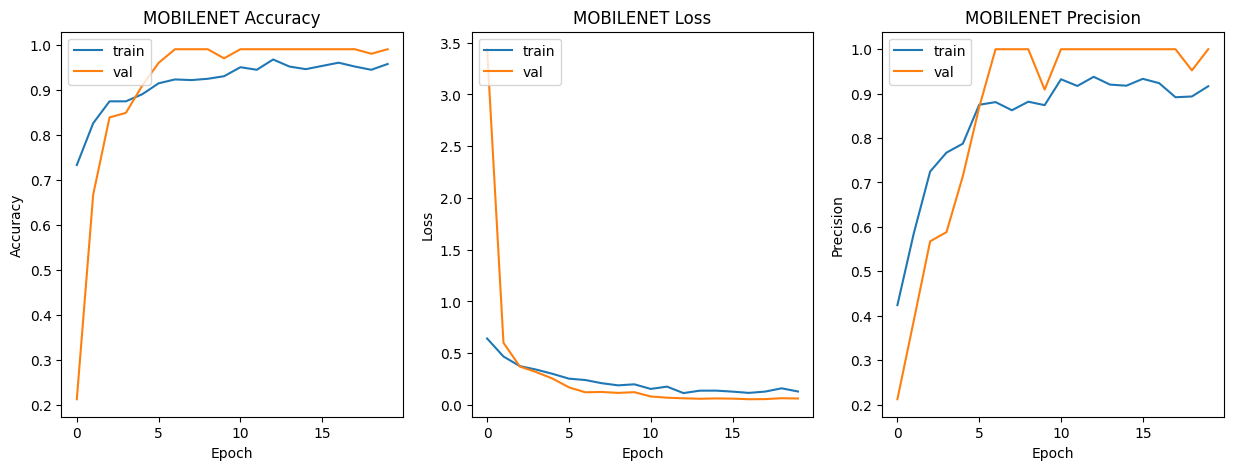

In [19]:
plot_history(MOBILENET_history, 'MOBILENET')

<h1 align="center" ><a id='vgg19'><b>VGG19<b></a></h1>

In [64]:
VGG19_base = tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG19_base.layers:
    layer.trainable = False

VGG19=tf.keras.Sequential()
VGG19.add(VGG19_base)
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Flatten())
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dropout(0.5))
VGG19.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG19.add(tf.keras.layers.BatchNormalization())
VGG19.add(tf.keras.layers.Activation('relu'))
VGG19.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG19.summary()

VGG19.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_20 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_122 (Ba  (None, 25088)            100352    
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 32)                802848    
                                                                 
 batch_normalization_123 (Ba  (None, 32)               128       
 tchNormalization)                                    

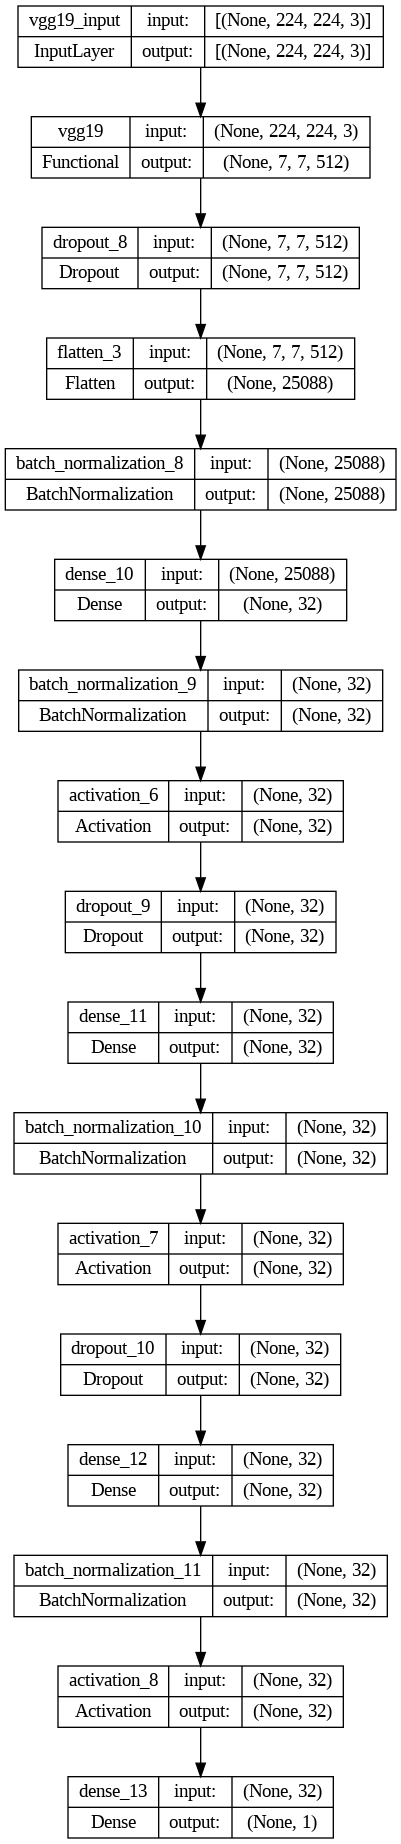

In [21]:
tf.keras.utils.plot_model(VGG19, to_file='./VGG19.png', show_shapes=True,show_layer_names=True)
Image(filename='VGG19.png')

In [65]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG19.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG19_history = VGG19.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6832 - Accuracy: 0.6903 - Precision: 0.3789 - Recall: 0.6856 - AUC: 0.7690 - F1: 0.3816

22/22 [==============================] - 17s 541ms/step - loss: 0.6832 - Accuracy: 0.6903 - Precision: 0.3789 - Recall: 0.6856 - AUC: 0.7690 - F1: 0.3816 - val_loss: 0.4726 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9542 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5373 - Accuracy: 0.7539 - Precision: 0.4433 - Recall: 0.5733 - AUC: 0.7761 - F1: 0.4942

22/22 [==============================] - 11s 491ms/step - loss: 0.5373 - Accuracy: 0.7539 - Precision: 0.4433 - Recall: 0.5733 - AUC: 0.7761 - F1: 0.4942 - val_loss: 0.4401 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9481 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4654 - Accuracy: 0.8326 - Precision: 0.6279 - Recall: 0.5400 - AUC: 0.8274 - F1: 0.5775

22/22 [==============================] - 12s 521ms/step - loss: 0.4654 - Accuracy: 0.8326 - Precision: 0.6279 - Recall: 0.5400 - AUC: 0.8274 - F1: 0.5775 - val_loss: 0.3476 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_AUC: 0.9915 - val_F1: 0.1111 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4370 - Accuracy: 0.8283 - Precision: 0.6339 - Recall: 0.4733 - AUC: 0.8148 - F1: 0.5219

22/22 [==============================] - 12s 527ms/step - loss: 0.4370 - Accuracy: 0.8283 - Precision: 0.6339 - Recall: 0.4733 - AUC: 0.8148 - F1: 0.5219 - val_loss: 0.2799 - val_Accuracy: 0.8586 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_AUC: 0.9957 - val_F1: 0.3747 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3669 - Accuracy: 0.8784 - Precision: 0.8155 - Recall: 0.5600 - AUC: 0.8973 - F1: 0.6639

22/22 [==============================] - 12s 531ms/step - loss: 0.3669 - Accuracy: 0.8784 - Precision: 0.8155 - Recall: 0.5600 - AUC: 0.8973 - F1: 0.6639 - val_loss: 0.2977 - val_Accuracy: 0.8081 - val_Precision: 1.0000 - val_Recall: 0.0952 - val_AUC: 0.9933 - val_F1: 0.1000 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3425 - Accuracy: 0.8755 - Precision: 0.7944 - Recall: 0.5667 - AUC: 0.9023 - F1: 0.6674

22/22 [==============================] - 12s 537ms/step - loss: 0.3425 - Accuracy: 0.8755 - Precision: 0.7944 - Recall: 0.5667 - AUC: 0.9023 - F1: 0.6674 - val_loss: 0.2762 - val_Accuracy: 0.8384 - val_Precision: 1.0000 - val_Recall: 0.2381 - val_AUC: 0.9979 - val_F1: 0.5215 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3356 - Accuracy: 0.8856 - Precision: 0.8017 - Recall: 0.6200 - AUC: 0.8887 - F1: 0.6839

22/22 [==============================] - 12s 532ms/step - loss: 0.3356 - Accuracy: 0.8856 - Precision: 0.8017 - Recall: 0.6200 - AUC: 0.8887 - F1: 0.6839 - val_loss: 0.2042 - val_Accuracy: 0.9091 - val_Precision: 1.0000 - val_Recall: 0.5714 - val_AUC: 0.9982 - val_F1: 0.4945 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.3042 - Accuracy: 0.8913 - Precision: 0.8246 - Recall: 0.6267 - AUC: 0.9067 - F1: 0.7193

22/22 [==============================] - 11s 487ms/step - loss: 0.3042 - Accuracy: 0.8913 - Precision: 0.8246 - Recall: 0.6267 - AUC: 0.9067 - F1: 0.7193 - val_loss: 0.1751 - val_Accuracy: 0.9495 - val_Precision: 1.0000 - val_Recall: 0.7619 - val_AUC: 0.9963 - val_F1: 0.6499 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2960 - Accuracy: 0.8941 - Precision: 0.8333 - Recall: 0.6333 - AUC: 0.9187 - F1: 0.7167

22/22 [==============================] - 11s 498ms/step - loss: 0.2960 - Accuracy: 0.8941 - Precision: 0.8333 - Recall: 0.6333 - AUC: 0.9187 - F1: 0.7167 - val_loss: 0.1611 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9948 - val_F1: 0.7000 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2872 - Accuracy: 0.8956 - Precision: 0.8130 - Recall: 0.6667 - AUC: 0.9168 - F1: 0.7194

22/22 [==============================] - 12s 528ms/step - loss: 0.2872 - Accuracy: 0.8956 - Precision: 0.8130 - Recall: 0.6667 - AUC: 0.9168 - F1: 0.7194 - val_loss: 0.1396 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9951 - val_F1: 0.7222 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2454 - Accuracy: 0.9013 - Precision: 0.8347 - Recall: 0.6733 - AUC: 0.9493 - F1: 0.7370

22/22 [==============================] - 11s 520ms/step - loss: 0.2454 - Accuracy: 0.9013 - Precision: 0.8347 - Recall: 0.6733 - AUC: 0.9493 - F1: 0.7370 - val_loss: 0.1255 - val_Accuracy: 0.9495 - val_Precision: 1.0000 - val_Recall: 0.7619 - val_AUC: 0.9924 - val_F1: 0.6583 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2681 - Accuracy: 0.8999 - Precision: 0.8333 - Recall: 0.6667 - AUC: 0.9304 - F1: 0.7381

22/22 [==============================] - 12s 524ms/step - loss: 0.2681 - Accuracy: 0.8999 - Precision: 0.8333 - Recall: 0.6667 - AUC: 0.9304 - F1: 0.7381 - val_loss: 0.1210 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9927 - val_F1: 0.6583 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2083 - Accuracy: 0.9256 - Precision: 0.8769 - Recall: 0.7600 - AUC: 0.9601 - F1: 0.8041

22/22 [==============================] - 12s 528ms/step - loss: 0.2083 - Accuracy: 0.9256 - Precision: 0.8769 - Recall: 0.7600 - AUC: 0.9601 - F1: 0.8041 - val_loss: 0.1035 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9936 - val_F1: 0.7391 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.2208 - Accuracy: 0.9156 - Precision: 0.8760 - Recall: 0.7067 - AUC: 0.9522 - F1: 0.7830

22/22 [==============================] - 11s 482ms/step - loss: 0.2208 - Accuracy: 0.9156 - Precision: 0.8760 - Recall: 0.7067 - AUC: 0.9522 - F1: 0.7830 - val_loss: 0.0884 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9902 - val_F1: 0.9868 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1992 - Accuracy: 0.9270 - Precision: 0.8613 - Recall: 0.7867 - AUC: 0.9728 - F1: 0.8161

22/22 [==============================] - 11s 498ms/step - loss: 0.1992 - Accuracy: 0.9270 - Precision: 0.8613 - Recall: 0.7867 - AUC: 0.9728 - F1: 0.8161 - val_loss: 0.0936 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9808 - val_F1: 0.7353 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1778 - Accuracy: 0.9371 - Precision: 0.9015 - Recall: 0.7933 - AUC: 0.9740 - F1: 0.8381

22/22 [==============================] - 12s 525ms/step - loss: 0.1778 - Accuracy: 0.9371 - Precision: 0.9015 - Recall: 0.7933 - AUC: 0.9740 - F1: 0.8381 - val_loss: 0.0963 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9811 - val_F1: 0.7273 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1892 - Accuracy: 0.9285 - Precision: 0.8676 - Recall: 0.7867 - AUC: 0.9613 - F1: 0.8284

22/22 [==============================] - 12s 529ms/step - loss: 0.1892 - Accuracy: 0.9285 - Precision: 0.8676 - Recall: 0.7867 - AUC: 0.9613 - F1: 0.8284 - val_loss: 0.0854 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9829 - val_F1: 0.7333 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1819 - Accuracy: 0.9270 - Precision: 0.8414 - Recall: 0.8133 - AUC: 0.9695 - F1: 0.8131

22/22 [==============================] - 12s 529ms/step - loss: 0.1819 - Accuracy: 0.9270 - Precision: 0.8414 - Recall: 0.8133 - AUC: 0.9695 - F1: 0.8131 - val_loss: 0.0953 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9756 - val_F1: 0.9833 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.2382 - Accuracy: 0.9170 - Precision: 0.8433 - Recall: 0.7533 - AUC: 0.9388 - F1: 0.7739

22/22 [==============================] - 12s 528ms/step - loss: 0.2382 - Accuracy: 0.9170 - Precision: 0.8433 - Recall: 0.7533 - AUC: 0.9388 - F1: 0.7739 - val_loss: 0.0855 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9814 - val_F1: 0.9853 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1971 - Accuracy: 0.9185 - Precision: 0.8163 - Recall: 0.8000 - AUC: 0.9585 - F1: 0.7991
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 11s 495ms/step - loss: 0.1971 - Accuracy: 0.9185 - Precision: 0.8163 - Recall: 0.8000 - AUC: 0.9585 - F1: 0.7991 - val_loss: 0.0921 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9783 - val_F1: 0.9000 - lr: 0.0010
Epoch 20: early stopping


In [66]:
VGG19_scores = VGG19.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 151ms/step - loss: 0.1002 - Accuracy: 0.9653 - Precision: 0.8936 - Recall: 0.9545 - AUC: 0.9927 - F1: 0.8630


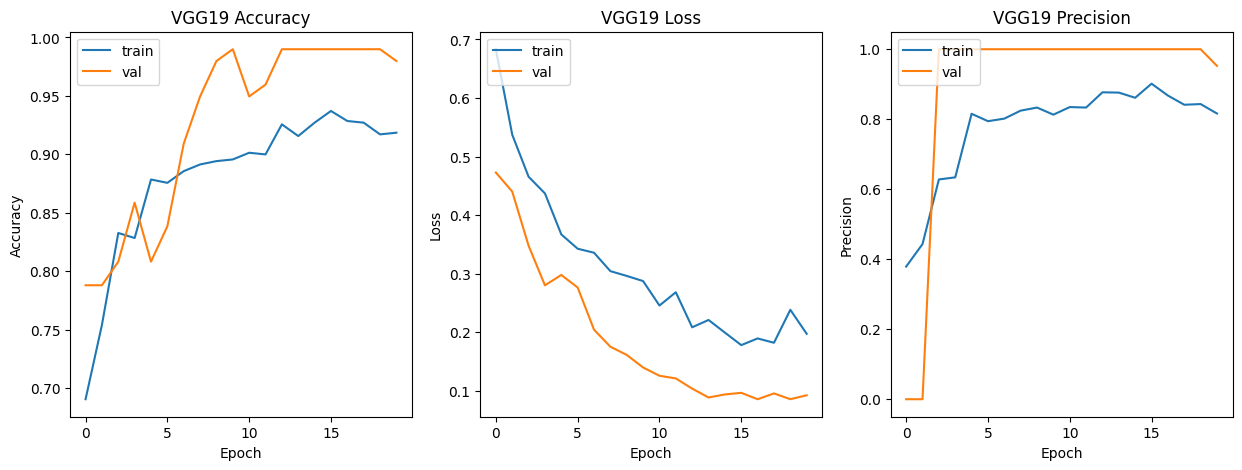

In [67]:
plot_history(VGG19_history, 'VGG19')

<h1 align="center" ><a id='xception'><b>Xception<b></a></h1>

In [24]:
Xception_base = tf.keras.applications.Xception(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in Xception_base.layers:
    layer.trainable = False

Xception=tf.keras.Sequential()
Xception.add(Xception_base)
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Flatten())
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dropout(0.5))
Xception.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
Xception.add(tf.keras.layers.BatchNormalization())
Xception.add(tf.keras.layers.Activation('relu'))
Xception.add(tf.keras.layers.Dense(1,activation='sigmoid'))

Xception.summary()

Xception.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_16 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_17 (Bat  (None, 32)               128       
 chNormalization)                                     

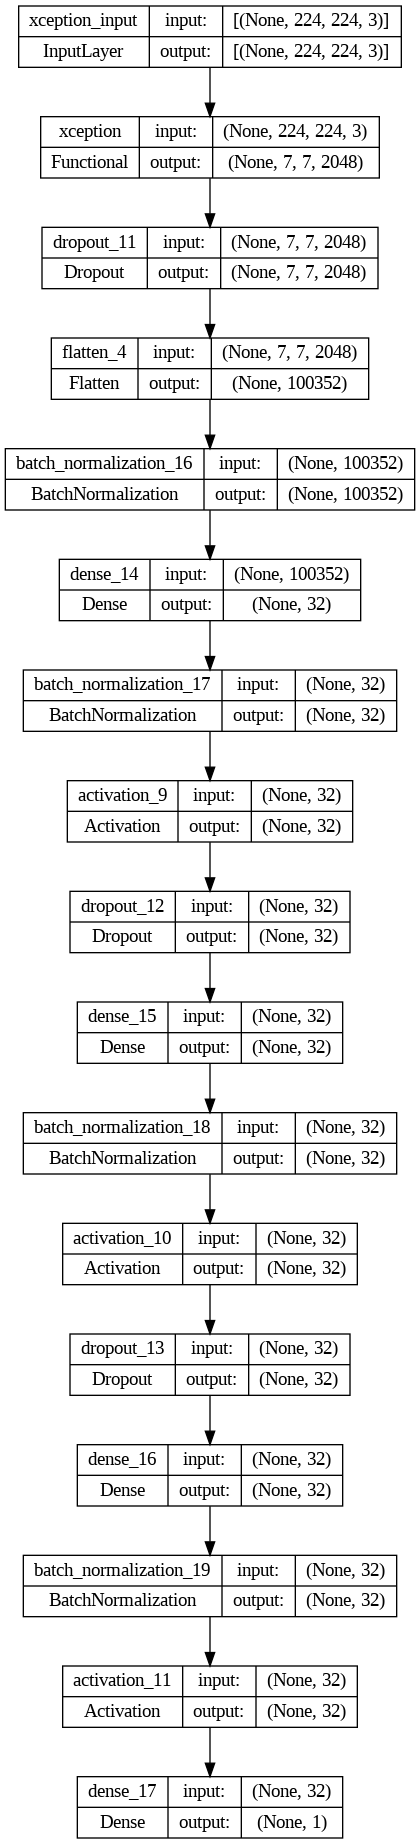

In [29]:
tf.keras.utils.plot_model(Xception, to_file='./Xception.png', show_shapes=True,show_layer_names=True)
Image(filename='Xception.png')

In [25]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('Xception.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

Xception_history = Xception.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.8584 - Accuracy: 0.4939 - Precision: 0.2866 - Recall: 0.9072 - AUC: 0.7864 - F1: 0.3622

22/22 [==============================] - 25s 828ms/step - loss: 0.8584 - Accuracy: 0.4939 - Precision: 0.2866 - Recall: 0.9072 - AUC: 0.7864 - F1: 0.3622 - val_loss: 0.3297 - val_Accuracy: 0.9293 - val_Precision: 0.8500 - val_Recall: 0.8095 - val_AUC: 0.9588 - val_F1: 0.8618 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.6523 - Accuracy: 0.5923 - Precision: 0.3200 - Recall: 0.8000 - AUC: 0.7753 - F1: 0.4563

22/22 [==============================] - 13s 598ms/step - loss: 0.6523 - Accuracy: 0.5923 - Precision: 0.3200 - Recall: 0.8000 - AUC: 0.7753 - F1: 0.4563 - val_loss: 0.3118 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9915 - val_F1: 0.9330 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.5291 - Accuracy: 0.7954 - Precision: 0.5161 - Recall: 0.7467 - AUC: 0.8380 - F1: 0.6069

22/22 [==============================] - 13s 586ms/step - loss: 0.5291 - Accuracy: 0.7954 - Precision: 0.5161 - Recall: 0.7467 - AUC: 0.8380 - F1: 0.6069 - val_loss: 0.3714 - val_Accuracy: 0.9394 - val_Precision: 0.8000 - val_Recall: 0.9524 - val_AUC: 0.9850 - val_F1: 0.8910 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4359 - Accuracy: 0.8784 - Precision: 0.7211 - Recall: 0.7067 - AUC: 0.8956 - F1: 0.7136

22/22 [==============================] - 13s 582ms/step - loss: 0.4359 - Accuracy: 0.8784 - Precision: 0.7211 - Recall: 0.7067 - AUC: 0.8956 - F1: 0.7136 - val_loss: 0.3686 - val_Accuracy: 0.9293 - val_Precision: 0.7692 - val_Recall: 0.9524 - val_AUC: 0.9939 - val_F1: 0.6365 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3847 - Accuracy: 0.8884 - Precision: 0.7769 - Recall: 0.6733 - AUC: 0.9125 - F1: 0.6911

22/22 [==============================] - 13s 576ms/step - loss: 0.3847 - Accuracy: 0.8884 - Precision: 0.7769 - Recall: 0.6733 - AUC: 0.9125 - F1: 0.6911 - val_loss: 0.3103 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9915 - val_F1: 0.9189 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3286 - Accuracy: 0.9056 - Precision: 0.8088 - Recall: 0.7333 - AUC: 0.9446 - F1: 0.7591

22/22 [==============================] - 13s 572ms/step - loss: 0.3286 - Accuracy: 0.9056 - Precision: 0.8088 - Recall: 0.7333 - AUC: 0.9446 - F1: 0.7591 - val_loss: 0.2557 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9963 - val_F1: 0.9104 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.2880 - Accuracy: 0.9142 - Precision: 0.8750 - Recall: 0.7000 - AUC: 0.9617 - F1: 0.7673

22/22 [==============================] - 13s 577ms/step - loss: 0.2880 - Accuracy: 0.9142 - Precision: 0.8750 - Recall: 0.7000 - AUC: 0.9617 - F1: 0.7673 - val_loss: 0.2172 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9933 - val_F1: 0.6937 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2750 - Accuracy: 0.9127 - Precision: 0.8560 - Recall: 0.7133 - AUC: 0.9364 - F1: 0.7740

22/22 [==============================] - 13s 579ms/step - loss: 0.2750 - Accuracy: 0.9127 - Precision: 0.8560 - Recall: 0.7133 - AUC: 0.9364 - F1: 0.7740 - val_loss: 0.1869 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9921 - val_F1: 0.6951 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2355 - Accuracy: 0.9242 - Precision: 0.9076 - Recall: 0.7200 - AUC: 0.9627 - F1: 0.7999

22/22 [==============================] - 13s 574ms/step - loss: 0.2355 - Accuracy: 0.9242 - Precision: 0.9076 - Recall: 0.7200 - AUC: 0.9627 - F1: 0.7999 - val_loss: 0.1659 - val_Accuracy: 0.9495 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9884 - val_F1: 0.9134 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2391 - Accuracy: 0.9099 - Precision: 0.8783 - Recall: 0.6733 - AUC: 0.9516 - F1: 0.7679

22/22 [==============================] - 12s 542ms/step - loss: 0.2391 - Accuracy: 0.9099 - Precision: 0.8783 - Recall: 0.6733 - AUC: 0.9516 - F1: 0.7679 - val_loss: 0.1441 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9905 - val_F1: 0.7214 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2001 - Accuracy: 0.9371 - Precision: 0.9015 - Recall: 0.7933 - AUC: 0.9607 - F1: 0.8342

22/22 [==============================] - 13s 575ms/step - loss: 0.2001 - Accuracy: 0.9371 - Precision: 0.9015 - Recall: 0.7933 - AUC: 0.9607 - F1: 0.8342 - val_loss: 0.1162 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9930 - val_F1: 0.9661 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.1874 - Accuracy: 0.9428 - Precision: 0.9231 - Recall: 0.8000 - AUC: 0.9779 - F1: 0.8580

22/22 [==============================] - 13s 577ms/step - loss: 0.1874 - Accuracy: 0.9428 - Precision: 0.9231 - Recall: 0.8000 - AUC: 0.9779 - F1: 0.8580 - val_loss: 0.1083 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9915 - val_F1: 0.9591 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.1823 - Accuracy: 0.9328 - Precision: 0.9120 - Recall: 0.7600 - AUC: 0.9751 - F1: 0.8174

22/22 [==============================] - 13s 576ms/step - loss: 0.1823 - Accuracy: 0.9328 - Precision: 0.9120 - Recall: 0.7600 - AUC: 0.9751 - F1: 0.8174 - val_loss: 0.1019 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9924 - val_F1: 0.9606 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.1783 - Accuracy: 0.9356 - Precision: 0.9008 - Recall: 0.7867 - AUC: 0.9737 - F1: 0.8304

22/22 [==============================] - 13s 594ms/step - loss: 0.1783 - Accuracy: 0.9356 - Precision: 0.9008 - Recall: 0.7867 - AUC: 0.9737 - F1: 0.8304 - val_loss: 0.0876 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9945 - val_F1: 0.7188 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1527 - Accuracy: 0.9442 - Precision: 0.9051 - Recall: 0.8267 - AUC: 0.9855 - F1: 0.8684

22/22 [==============================] - 13s 606ms/step - loss: 0.1527 - Accuracy: 0.9442 - Precision: 0.9051 - Recall: 0.8267 - AUC: 0.9855 - F1: 0.8684 - val_loss: 0.0893 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9945 - val_F1: 0.7222 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1912 - Accuracy: 0.9299 - Precision: 0.8686 - Recall: 0.7933 - AUC: 0.9629 - F1: 0.8024

22/22 [==============================] - 13s 596ms/step - loss: 0.1912 - Accuracy: 0.9299 - Precision: 0.8686 - Recall: 0.7933 - AUC: 0.9629 - F1: 0.8024 - val_loss: 0.0811 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9939 - val_F1: 0.7143 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1457 - Accuracy: 0.9499 - Precision: 0.9137 - Recall: 0.8467 - AUC: 0.9799 - F1: 0.8855

22/22 [==============================] - 13s 616ms/step - loss: 0.1457 - Accuracy: 0.9499 - Precision: 0.9137 - Recall: 0.8467 - AUC: 0.9799 - F1: 0.8855 - val_loss: 0.0698 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9930 - val_F1: 0.7273 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1485 - Accuracy: 0.9413 - Precision: 0.8978 - Recall: 0.8200 - AUC: 0.9796 - F1: 0.8508

22/22 [==============================] - 13s 598ms/step - loss: 0.1485 - Accuracy: 0.9413 - Precision: 0.8978 - Recall: 0.8200 - AUC: 0.9796 - F1: 0.8508 - val_loss: 0.0756 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9896 - val_F1: 0.7308 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.1810 - Accuracy: 0.9328 - Precision: 0.8705 - Recall: 0.8067 - AUC: 0.9683 - F1: 0.8356

22/22 [==============================] - 13s 586ms/step - loss: 0.1810 - Accuracy: 0.9328 - Precision: 0.8705 - Recall: 0.8067 - AUC: 0.9683 - F1: 0.8356 - val_loss: 0.0723 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9890 - val_F1: 0.7308 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.1504 - Accuracy: 0.9542 - Precision: 0.9338 - Recall: 0.8467 - AUC: 0.9764 - F1: 0.8929

22/22 [==============================] - 13s 593ms/step - loss: 0.1504 - Accuracy: 0.9542 - Precision: 0.9338 - Recall: 0.8467 - AUC: 0.9764 - F1: 0.8929 - val_loss: 0.0663 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9918 - val_F1: 0.9808 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.1314 - Accuracy: 0.9528 - Precision: 0.9034 - Recall: 0.8733 - AUC: 0.9845 - F1: 0.8788

22/22 [==============================] - 13s 602ms/step - loss: 0.1314 - Accuracy: 0.9528 - Precision: 0.9034 - Recall: 0.8733 - AUC: 0.9845 - F1: 0.8788 - val_loss: 0.0634 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.9773 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.1498 - Accuracy: 0.9456 - Precision: 0.8944 - Recall: 0.8467 - AUC: 0.9828 - F1: 0.8523

22/22 [==============================] - 13s 588ms/step - loss: 0.1498 - Accuracy: 0.9456 - Precision: 0.8944 - Recall: 0.8467 - AUC: 0.9828 - F1: 0.8523 - val_loss: 0.0555 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9969 - val_F1: 0.9773 - lr: 0.0010
Epoch 23/36
22/22 [==============================] - ETA: 0s - loss: 0.1171 - Accuracy: 0.9557 - Precision: 0.9281 - Recall: 0.8600 - AUC: 0.9891 - F1: 0.8932

22/22 [==============================] - 13s 607ms/step - loss: 0.1171 - Accuracy: 0.9557 - Precision: 0.9281 - Recall: 0.8600 - AUC: 0.9891 - F1: 0.8932 - val_loss: 0.0583 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9954 - val_F1: 0.9688 - lr: 0.0010
Epoch 24/36
22/22 [==============================] - ETA: 0s - loss: 0.1574 - Accuracy: 0.9442 - Precision: 0.8828 - Recall: 0.8533 - AUC: 0.9763 - F1: 0.8652

22/22 [==============================] - 13s 585ms/step - loss: 0.1574 - Accuracy: 0.9442 - Precision: 0.8828 - Recall: 0.8533 - AUC: 0.9763 - F1: 0.8652 - val_loss: 0.0590 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9973 - val_F1: 0.7250 - lr: 0.0010
Epoch 25/36
22/22 [==============================] - ETA: 0s - loss: 0.1243 - Accuracy: 0.9571 - Precision: 0.9225 - Recall: 0.8733 - AUC: 0.9848 - F1: 0.9008
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 13s 595ms/step - loss: 0.1243 - Accuracy: 0.9571 - Precision: 0.9225 - Recall: 0.8733 - AUC: 0.9848 - F1: 0.9008 - val_loss: 0.0587 - val_Accuracy: 0.9798 - val_Precision: 0.9524 - val_Recall: 0.9524 - val_AUC: 0.9957 - val_F1: 0.7188 - lr: 0.0010
Epoch 25: early stopping


In [26]:
Xception_scores = Xception.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 259ms/step - loss: 0.0346 - Accuracy: 0.9851 - Precision: 0.9362 - Recall: 1.0000 - AUC: 0.9997 - F1: 0.8487


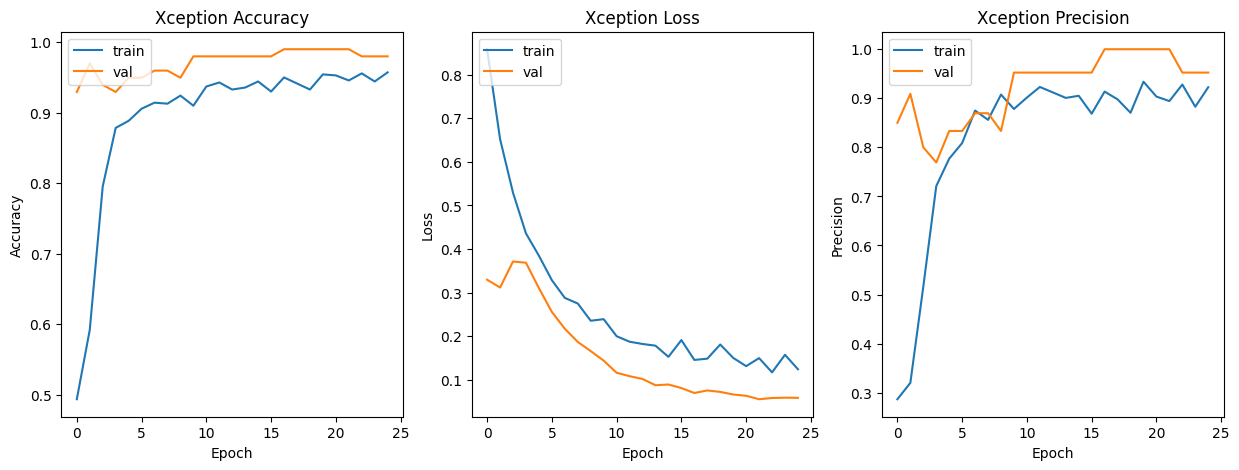

In [27]:
plot_history(Xception_history, 'Xception')

<h1 align="center" ><a id='inceptionv3'><b>InceptionV3<b></a></h1>

In [28]:
InceptionV3_base = tf.keras.applications.InceptionV3(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in InceptionV3_base.layers:
    layer.trainable = False

InceptionV3=tf.keras.Sequential()
InceptionV3.add(InceptionV3_base)
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Flatten())
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dropout(0.5))
InceptionV3.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
InceptionV3.add(tf.keras.layers.BatchNormalization())
InceptionV3.add(tf.keras.layers.Activation('relu'))
InceptionV3.add(tf.keras.layers.Dense(1,activation='sigmoid'))

InceptionV3.summary()

InceptionV3.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_14 (Dropout)        (None, 5, 5, 2048)        0         
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_114 (Ba  (None, 51200)            204800    
 tchNormalization)                                               
                                                                 
 dense_18 (Dense)            (None, 32)                1638432   
                                                                 
 batch_normalization_115 (Ba  (None, 32)               128       
 tchNormalization)                                    

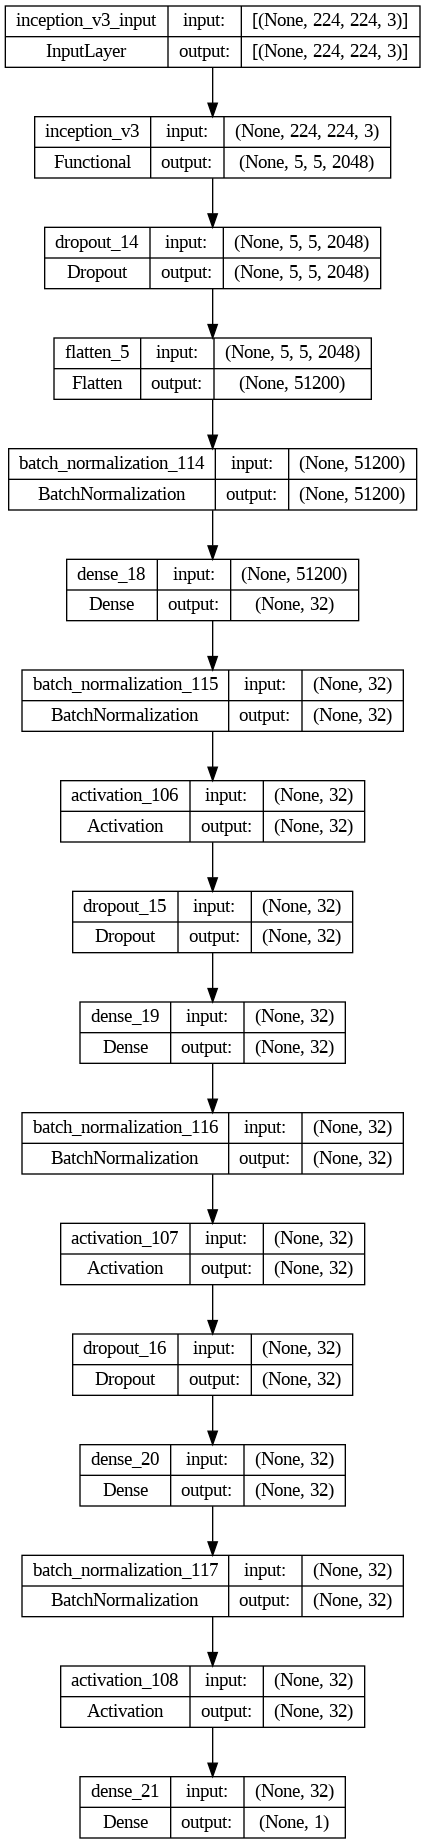

In [34]:
tf.keras.utils.plot_model(InceptionV3, to_file='./InceptionV3.png', show_shapes=True,show_layer_names=True)
Image(filename='InceptionV3.png')

In [29]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('InceptionV3.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

InceptionV3_history = InceptionV3.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5909 - Accuracy: 0.7425 - Precision: 0.4291 - Recall: 0.5928 - AUC: 0.7963 - F1: 0.3874

22/22 [==============================] - 26s 740ms/step - loss: 0.5909 - Accuracy: 0.7425 - Precision: 0.4291 - Recall: 0.5928 - AUC: 0.7963 - F1: 0.3874 - val_loss: 0.3043 - val_Accuracy: 0.8687 - val_Precision: 1.0000 - val_Recall: 0.3810 - val_AUC: 0.9701 - val_F1: 0.5492 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4602 - Accuracy: 0.8197 - Precision: 0.5896 - Recall: 0.5267 - AUC: 0.8070 - F1: 0.5476

22/22 [==============================] - 12s 567ms/step - loss: 0.4602 - Accuracy: 0.8197 - Precision: 0.5896 - Recall: 0.5267 - AUC: 0.8070 - F1: 0.5476 - val_loss: 0.2323 - val_Accuracy: 0.8788 - val_Precision: 1.0000 - val_Recall: 0.4286 - val_AUC: 0.9707 - val_F1: 0.4173 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.3630 - Accuracy: 0.8798 - Precision: 0.7750 - Recall: 0.6200 - AUC: 0.8956 - F1: 0.6916

22/22 [==============================] - 13s 571ms/step - loss: 0.3630 - Accuracy: 0.8798 - Precision: 0.7750 - Recall: 0.6200 - AUC: 0.8956 - F1: 0.6916 - val_loss: 0.1353 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9963 - val_F1: 0.6891 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3453 - Accuracy: 0.8741 - Precision: 0.7627 - Recall: 0.6000 - AUC: 0.8892 - F1: 0.6603

22/22 [==============================] - 12s 565ms/step - loss: 0.3453 - Accuracy: 0.8741 - Precision: 0.7627 - Recall: 0.6000 - AUC: 0.8892 - F1: 0.6603 - val_loss: 0.1462 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9957 - val_F1: 0.8833 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3214 - Accuracy: 0.8784 - Precision: 0.7642 - Recall: 0.6267 - AUC: 0.9099 - F1: 0.6765

22/22 [==============================] - 12s 565ms/step - loss: 0.3214 - Accuracy: 0.8784 - Precision: 0.7642 - Recall: 0.6267 - AUC: 0.9099 - F1: 0.6765 - val_loss: 0.1402 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9969 - val_F1: 0.9164 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.2879 - Accuracy: 0.8884 - Precision: 0.7857 - Recall: 0.6600 - AUC: 0.9291 - F1: 0.6991

22/22 [==============================] - 12s 561ms/step - loss: 0.2879 - Accuracy: 0.8884 - Precision: 0.7857 - Recall: 0.6600 - AUC: 0.9291 - F1: 0.6991 - val_loss: 0.1259 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 1.0000 - val_F1: 0.6976 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.2520 - Accuracy: 0.9127 - Precision: 0.8678 - Recall: 0.7000 - AUC: 0.9383 - F1: 0.7716

22/22 [==============================] - 12s 533ms/step - loss: 0.2520 - Accuracy: 0.9127 - Precision: 0.8678 - Recall: 0.7000 - AUC: 0.9383 - F1: 0.7716 - val_loss: 0.1329 - val_Accuracy: 0.9798 - val_Precision: 0.9130 - val_Recall: 1.0000 - val_AUC: 0.9982 - val_F1: 0.7167 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2331 - Accuracy: 0.9056 - Precision: 0.8281 - Recall: 0.7067 - AUC: 0.9572 - F1: 0.7568

22/22 [==============================] - 12s 564ms/step - loss: 0.2331 - Accuracy: 0.9056 - Precision: 0.8281 - Recall: 0.7067 - AUC: 0.9572 - F1: 0.7568 - val_loss: 0.1357 - val_Accuracy: 0.9697 - val_Precision: 0.8750 - val_Recall: 1.0000 - val_AUC: 0.9976 - val_F1: 0.9449 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2216 - Accuracy: 0.9270 - Precision: 0.8898 - Recall: 0.7533 - AUC: 0.9562 - F1: 0.8069

22/22 [==============================] - 12s 565ms/step - loss: 0.2216 - Accuracy: 0.9270 - Precision: 0.8898 - Recall: 0.7533 - AUC: 0.9562 - F1: 0.8069 - val_loss: 0.1122 - val_Accuracy: 0.9798 - val_Precision: 0.9130 - val_Recall: 1.0000 - val_AUC: 1.0000 - val_F1: 0.7222 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.1963 - Accuracy: 0.9199 - Precision: 0.8917 - Recall: 0.7133 - AUC: 0.9713 - F1: 0.7867

22/22 [==============================] - 12s 563ms/step - loss: 0.1963 - Accuracy: 0.9199 - Precision: 0.8917 - Recall: 0.7133 - AUC: 0.9713 - F1: 0.7867 - val_loss: 0.1127 - val_Accuracy: 0.9394 - val_Precision: 0.8571 - val_Recall: 0.8571 - val_AUC: 0.9939 - val_F1: 0.8987 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.1766 - Accuracy: 0.9328 - Precision: 0.9055 - Recall: 0.7667 - AUC: 0.9776 - F1: 0.8294

22/22 [==============================] - 12s 560ms/step - loss: 0.1766 - Accuracy: 0.9328 - Precision: 0.9055 - Recall: 0.7667 - AUC: 0.9776 - F1: 0.8294 - val_loss: 0.0966 - val_Accuracy: 0.9899 - val_Precision: 0.9545 - val_Recall: 1.0000 - val_AUC: 0.9976 - val_F1: 0.9808 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.1881 - Accuracy: 0.9299 - Precision: 0.8976 - Recall: 0.7600 - AUC: 0.9720 - F1: 0.8238

22/22 [==============================] - 12s 557ms/step - loss: 0.1881 - Accuracy: 0.9299 - Precision: 0.8976 - Recall: 0.7600 - AUC: 0.9720 - F1: 0.8238 - val_loss: 0.0713 - val_Accuracy: 0.9899 - val_Precision: 0.9545 - val_Recall: 1.0000 - val_AUC: 1.0000 - val_F1: 0.7381 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.1845 - Accuracy: 0.9342 - Precision: 0.9262 - Recall: 0.7533 - AUC: 0.9678 - F1: 0.8318

22/22 [==============================] - 12s 521ms/step - loss: 0.1845 - Accuracy: 0.9342 - Precision: 0.9262 - Recall: 0.7533 - AUC: 0.9678 - F1: 0.8318 - val_loss: 0.0746 - val_Accuracy: 0.9798 - val_Precision: 0.9130 - val_Recall: 1.0000 - val_AUC: 1.0000 - val_F1: 0.7030 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.1629 - Accuracy: 0.9428 - Precision: 0.9044 - Recall: 0.8200 - AUC: 0.9718 - F1: 0.8614

22/22 [==============================] - 12s 521ms/step - loss: 0.1629 - Accuracy: 0.9428 - Precision: 0.9044 - Recall: 0.8200 - AUC: 0.9718 - F1: 0.8614 - val_loss: 0.0703 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_AUC: 1.0000 - val_F1: 1.0000 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1667 - Accuracy: 0.9299 - Precision: 0.8582 - Recall: 0.8067 - AUC: 0.9760 - F1: 0.8201

22/22 [==============================] - 12s 562ms/step - loss: 0.1667 - Accuracy: 0.9299 - Precision: 0.8582 - Recall: 0.8067 - AUC: 0.9760 - F1: 0.8201 - val_loss: 0.0700 - val_Accuracy: 0.9899 - val_Precision: 0.9545 - val_Recall: 1.0000 - val_AUC: 0.9982 - val_F1: 0.7273 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1661 - Accuracy: 0.9499 - Precision: 0.9528 - Recall: 0.8067 - AUC: 0.9715 - F1: 0.8724

22/22 [==============================] - 12s 559ms/step - loss: 0.1661 - Accuracy: 0.9499 - Precision: 0.9528 - Recall: 0.8067 - AUC: 0.9715 - F1: 0.8724 - val_loss: 0.0728 - val_Accuracy: 0.9596 - val_Precision: 0.9474 - val_Recall: 0.8571 - val_AUC: 0.9982 - val_F1: 0.9451 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.1679 - Accuracy: 0.9456 - Precision: 0.8944 - Recall: 0.8467 - AUC: 0.9658 - F1: 0.8529

22/22 [==============================] - 12s 560ms/step - loss: 0.1679 - Accuracy: 0.9456 - Precision: 0.8944 - Recall: 0.8467 - AUC: 0.9658 - F1: 0.8529 - val_loss: 0.1030 - val_Accuracy: 0.9495 - val_Precision: 0.9000 - val_Recall: 0.8571 - val_AUC: 0.9945 - val_F1: 0.6606 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.1663 - Accuracy: 0.9399 - Precision: 0.8857 - Recall: 0.8267 - AUC: 0.9752 - F1: 0.8491
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 552ms/step - loss: 0.1663 - Accuracy: 0.9399 - Precision: 0.8857 - Recall: 0.8267 - AUC: 0.9752 - F1: 0.8491 - val_loss: 0.1018 - val_Accuracy: 0.9596 - val_Precision: 0.9474 - val_Recall: 0.8571 - val_AUC: 0.9908 - val_F1: 0.6867 - lr: 0.0010
Epoch 18: early stopping


In [30]:
InceptionV3_scores = InceptionV3.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 303ms/step - loss: 0.1044 - Accuracy: 0.9604 - Precision: 0.9091 - Recall: 0.9091 - AUC: 0.9934 - F1: 0.8962


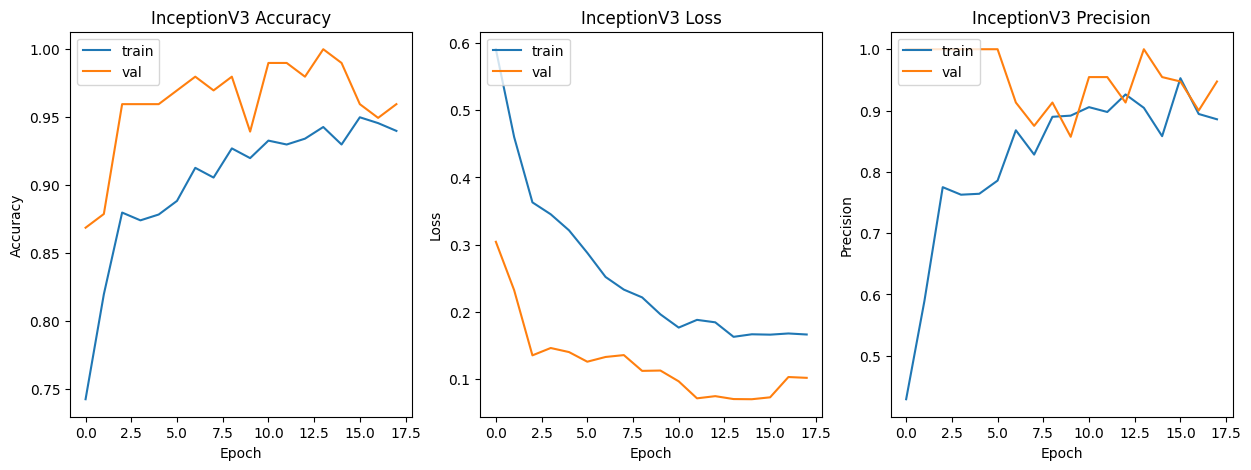

In [31]:
plot_history(InceptionV3_history, 'InceptionV3')

<h1 align="center" ><a id='resnet50'><b>ResNet50<b></a></h1>

In [32]:
ResNet50_base = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50=tf.keras.Sequential()
ResNet50.add(ResNet50_base)
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Flatten())
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dropout(0.5))
ResNet50.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
ResNet50.add(tf.keras.layers.BatchNormalization())
ResNet50.add(tf.keras.layers.Activation('relu'))
ResNet50.add(tf.keras.layers.Dense(1,activation='sigmoid'))

ResNet50.summary()

ResNet50.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_17 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_118 (Ba  (None, 100352)           401408    
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_119 (Ba  (None, 32)               128       
 tchNormalization)                                    

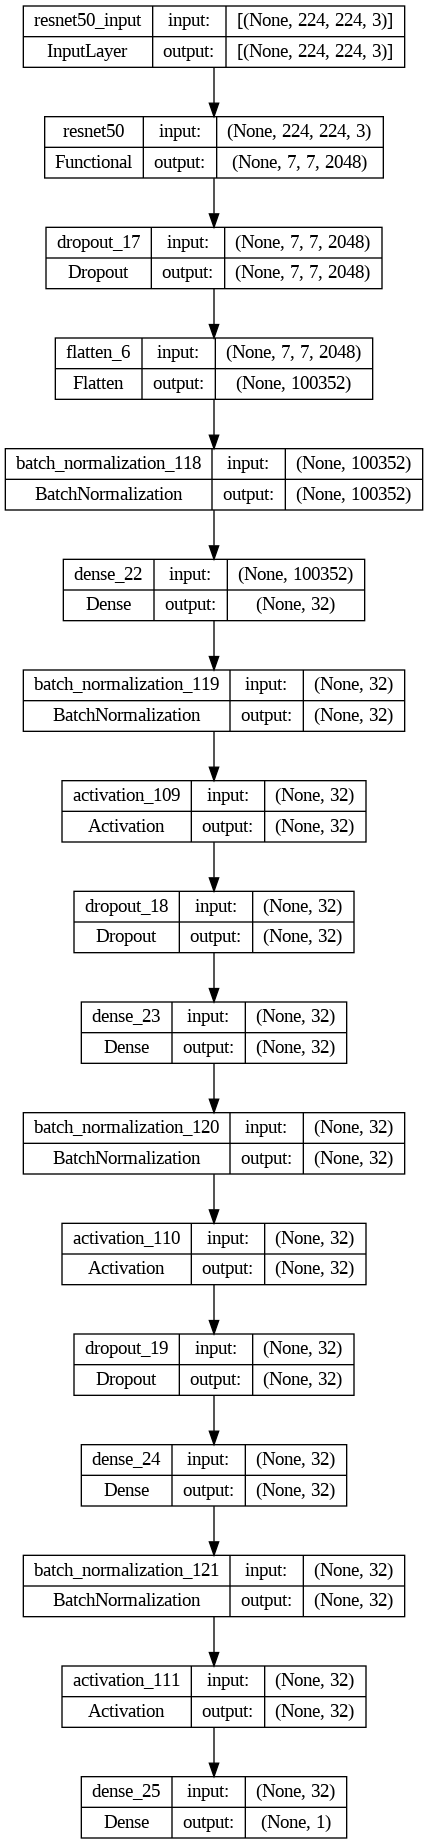

In [39]:
tf.keras.utils.plot_model(ResNet50, to_file='./ResNet50.png', show_shapes=True,show_layer_names=True)
Image(filename='ResNet50.png')

In [33]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('ResNet50.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

ResNet50_history = ResNet50.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.6486 - Accuracy: 0.7026 - Precision: 0.3484 - Recall: 0.4381 - AUC: 0.7037 - F1: 0.2432

22/22 [==============================] - 23s 671ms/step - loss: 0.6486 - Accuracy: 0.7026 - Precision: 0.3484 - Recall: 0.4381 - AUC: 0.7037 - F1: 0.2432 - val_loss: 0.5637 - val_Accuracy: 0.7980 - val_Precision: 1.0000 - val_Recall: 0.0476 - val_AUC: 0.7128 - val_F1: 0.0625 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.5319 - Accuracy: 0.7496 - Precision: 0.3737 - Recall: 0.2467 - AUC: 0.6777 - F1: 0.2982

22/22 [==============================] - 13s 569ms/step - loss: 0.5319 - Accuracy: 0.7496 - Precision: 0.3737 - Recall: 0.2467 - AUC: 0.6777 - F1: 0.2982 - val_loss: 0.4344 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.8919 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4877 - Accuracy: 0.8040 - Precision: 0.5823 - Recall: 0.3067 - AUC: 0.7106 - F1: 0.3976

22/22 [==============================] - 12s 564ms/step - loss: 0.4877 - Accuracy: 0.8040 - Precision: 0.5823 - Recall: 0.3067 - AUC: 0.7106 - F1: 0.3976 - val_loss: 0.4545 - val_Accuracy: 0.7980 - val_Precision: 1.0000 - val_Recall: 0.0476 - val_AUC: 0.9014 - val_F1: 0.0625 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4640 - Accuracy: 0.7969 - Precision: 0.5667 - Recall: 0.2267 - AUC: 0.7402 - F1: 0.3129

22/22 [==============================] - 13s 588ms/step - loss: 0.4640 - Accuracy: 0.7969 - Precision: 0.5667 - Recall: 0.2267 - AUC: 0.7402 - F1: 0.3129 - val_loss: 0.3782 - val_Accuracy: 0.8586 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_AUC: 0.8526 - val_F1: 0.3644 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.4444 - Accuracy: 0.8083 - Precision: 0.6538 - Recall: 0.2267 - AUC: 0.7518 - F1: 0.3244

22/22 [==============================] - 12s 563ms/step - loss: 0.4444 - Accuracy: 0.8083 - Precision: 0.6538 - Recall: 0.2267 - AUC: 0.7518 - F1: 0.3244 - val_loss: 0.3445 - val_Accuracy: 0.8384 - val_Precision: 0.7778 - val_Recall: 0.3333 - val_AUC: 0.8895 - val_F1: 0.3472 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.4177 - Accuracy: 0.8255 - Precision: 0.7333 - Recall: 0.2933 - AUC: 0.7980 - F1: 0.4194

22/22 [==============================] - 12s 532ms/step - loss: 0.4177 - Accuracy: 0.8255 - Precision: 0.7333 - Recall: 0.2933 - AUC: 0.7980 - F1: 0.4194 - val_loss: 0.2671 - val_Accuracy: 0.8889 - val_Precision: 0.8571 - val_Recall: 0.5714 - val_AUC: 0.9332 - val_F1: 0.7491 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.4152 - Accuracy: 0.8212 - Precision: 0.7049 - Recall: 0.2867 - AUC: 0.8041 - F1: 0.3820

22/22 [==============================] - 12s 544ms/step - loss: 0.4152 - Accuracy: 0.8212 - Precision: 0.7049 - Recall: 0.2867 - AUC: 0.8041 - F1: 0.3820 - val_loss: 0.2451 - val_Accuracy: 0.8889 - val_Precision: 0.8125 - val_Recall: 0.6190 - val_AUC: 0.9377 - val_F1: 0.7421 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.3991 - Accuracy: 0.8269 - Precision: 0.6986 - Recall: 0.3400 - AUC: 0.8179 - F1: 0.4573

22/22 [==============================] - 13s 569ms/step - loss: 0.3991 - Accuracy: 0.8269 - Precision: 0.6986 - Recall: 0.3400 - AUC: 0.8179 - F1: 0.4573 - val_loss: 0.2456 - val_Accuracy: 0.8889 - val_Precision: 0.7778 - val_Recall: 0.6667 - val_AUC: 0.9383 - val_F1: 0.5287 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.3917 - Accuracy: 0.8355 - Precision: 0.7536 - Recall: 0.3467 - AUC: 0.8229 - F1: 0.4869

22/22 [==============================] - 12s 561ms/step - loss: 0.3917 - Accuracy: 0.8355 - Precision: 0.7536 - Recall: 0.3467 - AUC: 0.8229 - F1: 0.4869 - val_loss: 0.2513 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9261 - val_F1: 0.7354 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.3729 - Accuracy: 0.8512 - Precision: 0.7949 - Recall: 0.4133 - AUC: 0.8465 - F1: 0.5386

22/22 [==============================] - 12s 564ms/step - loss: 0.3729 - Accuracy: 0.8512 - Precision: 0.7949 - Recall: 0.4133 - AUC: 0.8465 - F1: 0.5386 - val_loss: 0.2416 - val_Accuracy: 0.9192 - val_Precision: 0.8824 - val_Recall: 0.7143 - val_AUC: 0.9368 - val_F1: 0.5848 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.3936 - Accuracy: 0.8355 - Precision: 0.7273 - Recall: 0.3733 - AUC: 0.8166 - F1: 0.4689

22/22 [==============================] - 12s 564ms/step - loss: 0.3936 - Accuracy: 0.8355 - Precision: 0.7273 - Recall: 0.3733 - AUC: 0.8166 - F1: 0.4689 - val_loss: 0.2362 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9371 - val_F1: 0.8352 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.3641 - Accuracy: 0.8455 - Precision: 0.7561 - Recall: 0.4133 - AUC: 0.8469 - F1: 0.5320

22/22 [==============================] - 12s 566ms/step - loss: 0.3641 - Accuracy: 0.8455 - Precision: 0.7561 - Recall: 0.4133 - AUC: 0.8469 - F1: 0.5320 - val_loss: 0.2151 - val_Accuracy: 0.9091 - val_Precision: 0.8333 - val_Recall: 0.7143 - val_AUC: 0.9551 - val_F1: 0.7529 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.3581 - Accuracy: 0.8598 - Precision: 0.7826 - Recall: 0.4800 - AUC: 0.8525 - F1: 0.5953

22/22 [==============================] - 12s 564ms/step - loss: 0.3581 - Accuracy: 0.8598 - Precision: 0.7826 - Recall: 0.4800 - AUC: 0.8525 - F1: 0.5953 - val_loss: 0.2184 - val_Accuracy: 0.8990 - val_Precision: 0.7895 - val_Recall: 0.7143 - val_AUC: 0.9573 - val_F1: 0.7908 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.3509 - Accuracy: 0.8598 - Precision: 0.7708 - Recall: 0.4933 - AUC: 0.8567 - F1: 0.6119

22/22 [==============================] - 12s 544ms/step - loss: 0.3509 - Accuracy: 0.8598 - Precision: 0.7708 - Recall: 0.4933 - AUC: 0.8567 - F1: 0.6119 - val_loss: 0.2248 - val_Accuracy: 0.8687 - val_Precision: 0.6818 - val_Recall: 0.7143 - val_AUC: 0.9701 - val_F1: 0.4765 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.3387 - Accuracy: 0.8698 - Precision: 0.8315 - Recall: 0.4933 - AUC: 0.8656 - F1: 0.6179

22/22 [==============================] - 12s 559ms/step - loss: 0.3387 - Accuracy: 0.8698 - Precision: 0.8315 - Recall: 0.4933 - AUC: 0.8656 - F1: 0.6179 - val_loss: 0.1970 - val_Accuracy: 0.8990 - val_Precision: 0.7895 - val_Recall: 0.7143 - val_AUC: 0.9744 - val_F1: 0.5558 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.3485 - Accuracy: 0.8684 - Precision: 0.8085 - Recall: 0.5067 - AUC: 0.8632 - F1: 0.5885

22/22 [==============================] - 12s 561ms/step - loss: 0.3485 - Accuracy: 0.8684 - Precision: 0.8085 - Recall: 0.5067 - AUC: 0.8632 - F1: 0.5885 - val_loss: 0.2007 - val_Accuracy: 0.9192 - val_Precision: 0.8824 - val_Recall: 0.7143 - val_AUC: 0.9658 - val_F1: 0.6090 - lr: 0.0010
Epoch 17/36
22/22 [==============================] - ETA: 0s - loss: 0.3241 - Accuracy: 0.8670 - Precision: 0.8065 - Recall: 0.5000 - AUC: 0.8937 - F1: 0.6149

22/22 [==============================] - 12s 563ms/step - loss: 0.3241 - Accuracy: 0.8670 - Precision: 0.8065 - Recall: 0.5000 - AUC: 0.8937 - F1: 0.6149 - val_loss: 0.2085 - val_Accuracy: 0.9091 - val_Precision: 0.8000 - val_Recall: 0.7619 - val_AUC: 0.9686 - val_F1: 0.5908 - lr: 0.0010
Epoch 18/36
22/22 [==============================] - ETA: 0s - loss: 0.3516 - Accuracy: 0.8598 - Precision: 0.7453 - Recall: 0.5267 - AUC: 0.8744 - F1: 0.6123

22/22 [==============================] - 12s 566ms/step - loss: 0.3516 - Accuracy: 0.8598 - Precision: 0.7453 - Recall: 0.5267 - AUC: 0.8744 - F1: 0.6123 - val_loss: 0.1955 - val_Accuracy: 0.9394 - val_Precision: 0.8261 - val_Recall: 0.9048 - val_AUC: 0.9792 - val_F1: 0.6444 - lr: 0.0010
Epoch 19/36
22/22 [==============================] - ETA: 0s - loss: 0.3056 - Accuracy: 0.8727 - Precision: 0.8081 - Recall: 0.5333 - AUC: 0.9041 - F1: 0.6297

22/22 [==============================] - 12s 555ms/step - loss: 0.3056 - Accuracy: 0.8727 - Precision: 0.8081 - Recall: 0.5333 - AUC: 0.9041 - F1: 0.6297 - val_loss: 0.1899 - val_Accuracy: 0.9091 - val_Precision: 0.8000 - val_Recall: 0.7619 - val_AUC: 0.9786 - val_F1: 0.8164 - lr: 0.0010
Epoch 20/36
22/22 [==============================] - ETA: 0s - loss: 0.3192 - Accuracy: 0.8641 - Precision: 0.7619 - Recall: 0.5333 - AUC: 0.9023 - F1: 0.6066

22/22 [==============================] - 12s 560ms/step - loss: 0.3192 - Accuracy: 0.8641 - Precision: 0.7619 - Recall: 0.5333 - AUC: 0.9023 - F1: 0.6066 - val_loss: 0.1895 - val_Accuracy: 0.9293 - val_Precision: 0.7917 - val_Recall: 0.9048 - val_AUC: 0.9783 - val_F1: 0.6228 - lr: 0.0010
Epoch 21/36
22/22 [==============================] - ETA: 0s - loss: 0.3223 - Accuracy: 0.8498 - Precision: 0.6991 - Recall: 0.5267 - AUC: 0.8890 - F1: 0.6003

22/22 [==============================] - 12s 558ms/step - loss: 0.3223 - Accuracy: 0.8498 - Precision: 0.6991 - Recall: 0.5267 - AUC: 0.8890 - F1: 0.6003 - val_loss: 0.2112 - val_Accuracy: 0.9091 - val_Precision: 0.8000 - val_Recall: 0.7619 - val_AUC: 0.9667 - val_F1: 0.5891 - lr: 0.0010
Epoch 22/36
22/22 [==============================] - ETA: 0s - loss: 0.3237 - Accuracy: 0.8612 - Precision: 0.7624 - Recall: 0.5133 - AUC: 0.8922 - F1: 0.6327

22/22 [==============================] - 13s 569ms/step - loss: 0.3237 - Accuracy: 0.8612 - Precision: 0.7624 - Recall: 0.5133 - AUC: 0.8922 - F1: 0.6327 - val_loss: 0.2038 - val_Accuracy: 0.8889 - val_Precision: 0.7273 - val_Recall: 0.7619 - val_AUC: 0.9750 - val_F1: 0.5426 - lr: 0.0010
Epoch 23/36
22/22 [==============================] - ETA: 0s - loss: 0.2770 - Accuracy: 0.8898 - Precision: 0.8174 - Recall: 0.6267 - AUC: 0.9234 - F1: 0.7043
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 12s 544ms/step - loss: 0.2770 - Accuracy: 0.8898 - Precision: 0.8174 - Recall: 0.6267 - AUC: 0.9234 - F1: 0.7043 - val_loss: 0.1998 - val_Accuracy: 0.9091 - val_Precision: 0.8000 - val_Recall: 0.7619 - val_AUC: 0.9792 - val_F1: 0.8366 - lr: 0.0010
Epoch 23: early stopping


In [34]:
ResNet50_scores = ResNet50.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 220ms/step - loss: 0.1209 - Accuracy: 0.9604 - Precision: 0.9091 - Recall: 0.9091 - AUC: 0.9917 - F1: 0.9221


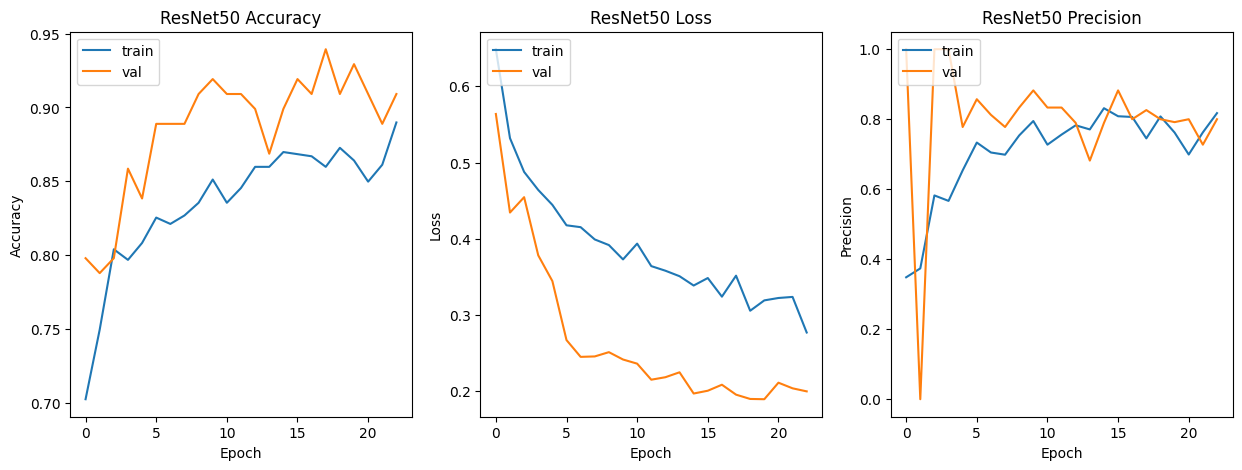

In [35]:
plot_history(ResNet50_history, 'ResNet50')

<div style='font-size:100%;'>
    <a id='example'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Example: Prediction vs Truth </center>
    </h1>
</div></center>

1/1 [==============================] - 0s 24ms/step


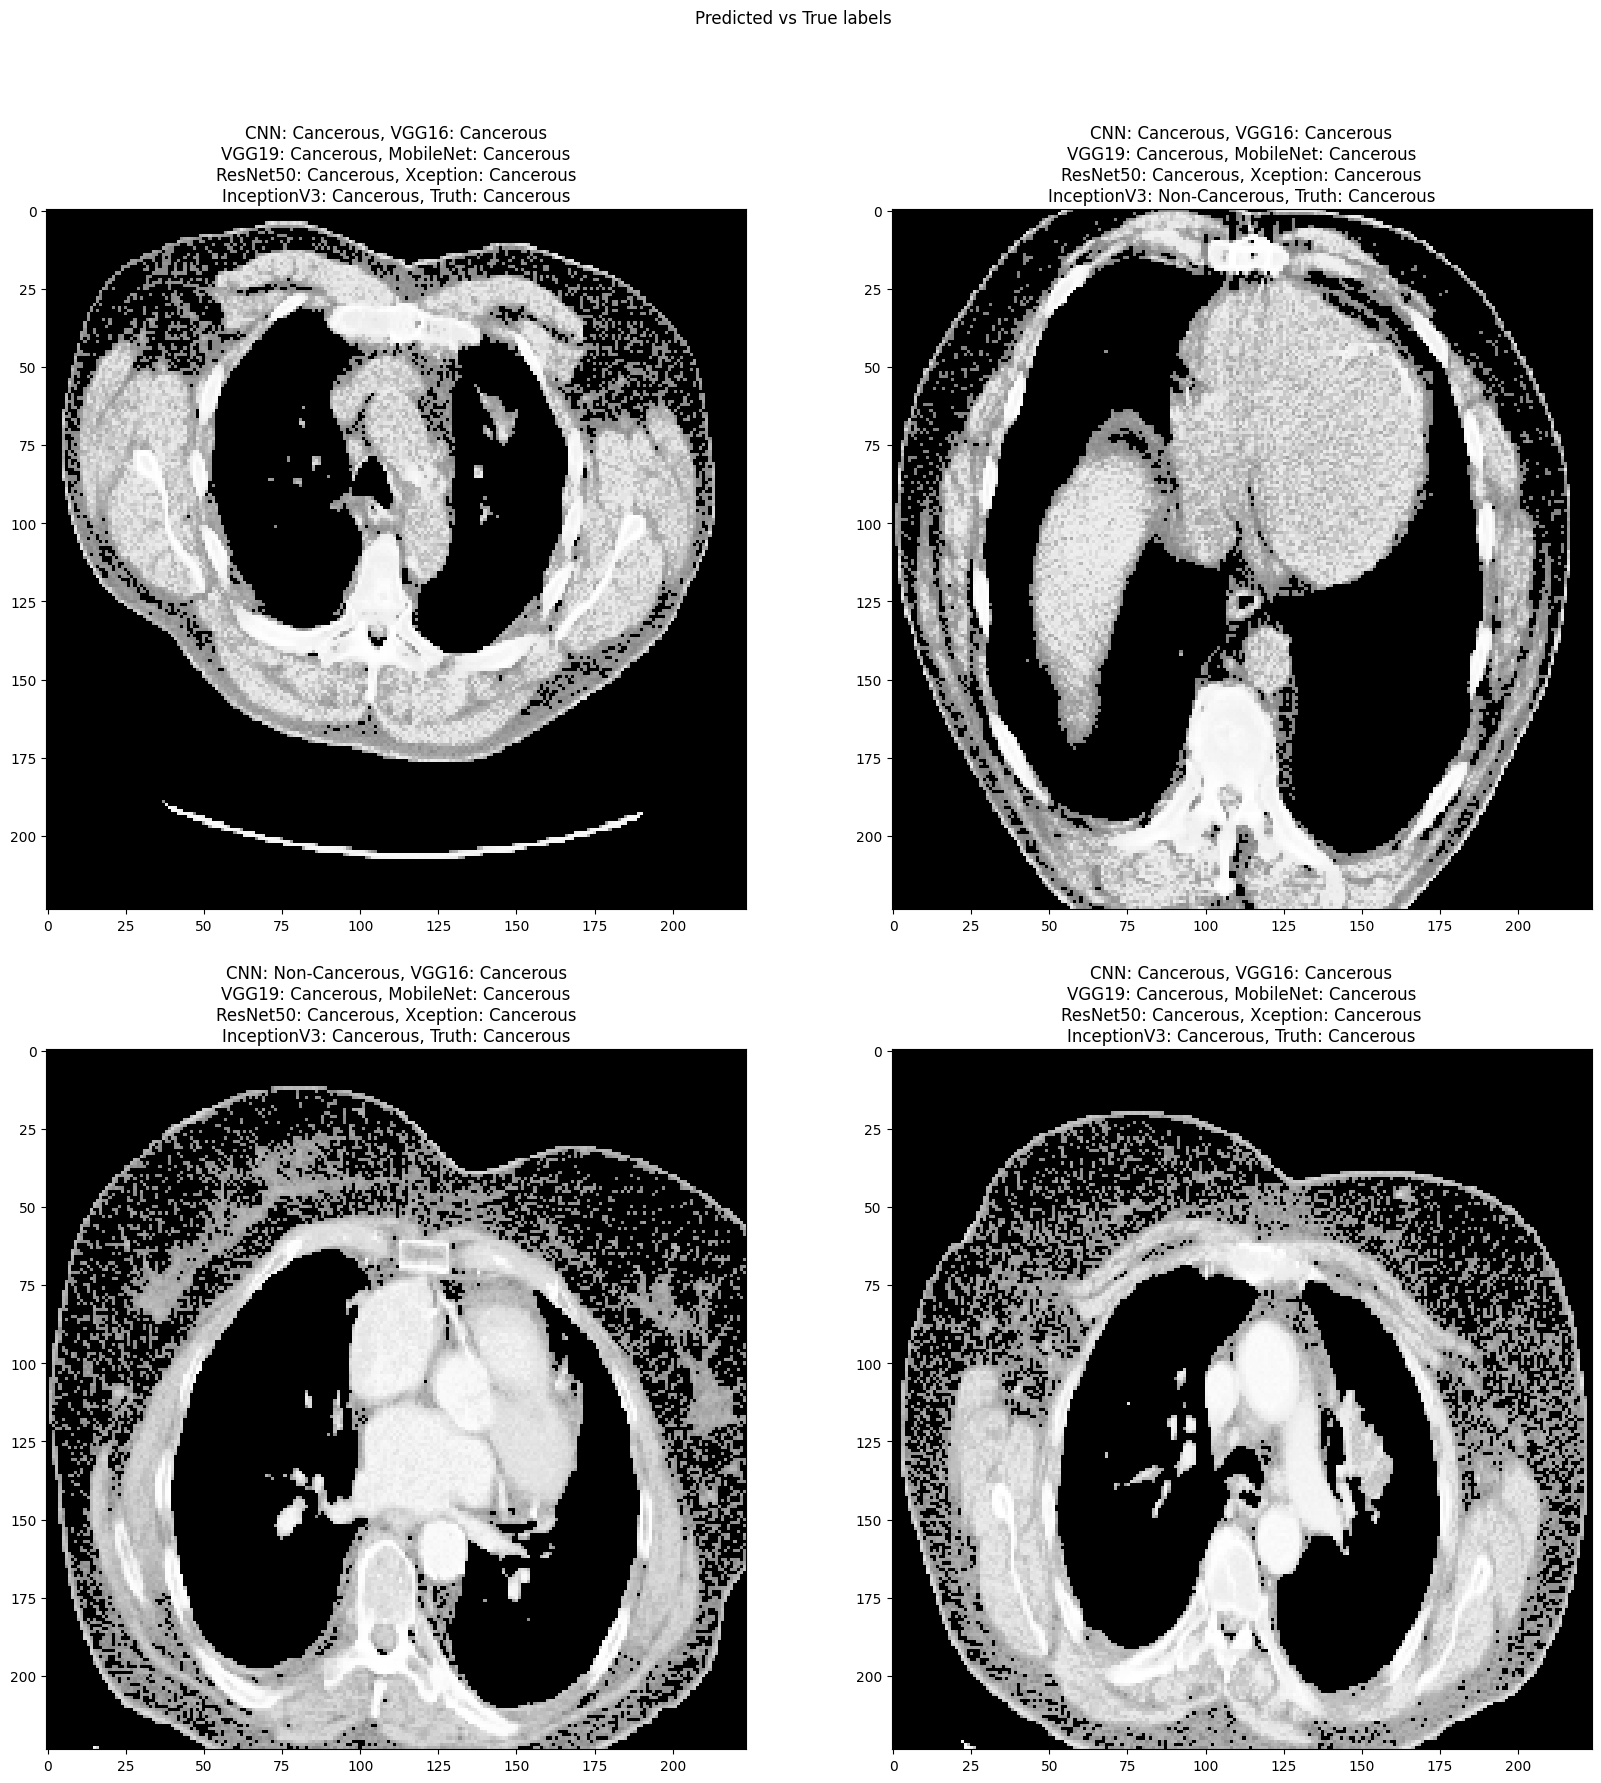

In [68]:
batch = next(test_dataset)

def predAll(batch, i):
  label_dict = {0: 'Cancerous', 1: 'Non-Cancerous'}
  cnnPred = 0 if CNN.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg16Pred = 0 if VGG16.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  mobilenetPred = 0 if MOBILENET.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  vgg19Pred = 0 if VGG19.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  xceptionPred = 0 if Xception.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  inceptionv3Pred = 0 if InceptionV3.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1
  resnet50Pred = 0 if ResNet50.predict(batch[0][i].reshape(-1, 224, 224, 3)) < 0.5 else 1

  return f'CNN: {label_dict[cnnPred]}, VGG16: {label_dict[vgg16Pred]}\nVGG19: {label_dict[vgg19Pred]}, MobileNet: {label_dict[mobilenetPred]}\nResNet50: {label_dict[resnet50Pred]}, Xception: {label_dict[xceptionPred]}\nInceptionV3: {label_dict[inceptionv3Pred]}, Truth: {label_dict[int(batch[1][i])]}'


plt.figure(figsize=(20, 20))

ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][0])
label = predAll(batch, 0)
ax1.set_title(label)


ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[0][5])
label = predAll(batch, 1)
ax2.set_title(label)

ax3 = plt.subplot(2, 2, 3)
plt.imshow(batch[0][2])
label = predAll(batch, 2)
ax3.set_title(label)

ax4 = plt.subplot(2, 2, 4)
plt.imshow(batch[0][3])
label = predAll(batch, 3)
ax4.set_title(label)


plt.suptitle('Predicted vs True labels')
plt.show()


In [69]:
eval = [CNN_scores, VGG16_scores, VGG19_scores, MOBILENET_scores, ResNet50_scores, Xception_scores, InceptionV3_scores]
eval

[[0.22808341681957245,
  0.9108911156654358,
  0.7166666388511658,
  0.9772727489471436,
  0.9841052889823914,
  0.8377150297164917],
 [0.06904060393571854,
  0.9900990128517151,
  0.95652174949646,
  1.0,
  0.999712347984314,
  0.9814921617507935],
 [0.10016016662120819,
  0.9653465151786804,
  0.8936170339584351,
  0.9545454382896423,
  0.9926639795303345,
  0.8629633188247681],
 [0.027856670320034027,
  0.9900990128517151,
  0.9772727489471436,
  0.9772727489471436,
  0.9997124075889587,
  0.9700680375099182],
 [0.12090688943862915,
  0.9603960514068604,
  0.9090909361839294,
  0.9090909361839294,
  0.9917290806770325,
  0.9220730066299438],
 [0.0346272811293602,
  0.9851484894752502,
  0.936170220375061,
  1.0,
  0.9997122883796692,
  0.848739504814148],
 [0.10441063344478607,
  0.9603960514068604,
  0.9090909361839294,
  0.9090909361839294,
  0.9933832287788391,
  0.8961862921714783]]

<div style='font-size:100%;'>
    <a id='analysis'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> Comparative analysis of the models </center>
    </h1>
</div></center>

In [71]:
indices = ['CNN', 'VGG16', 'VGG19', 'MobileNet', 'ResNet', 'Xception', 'InceptionV3']
scores = pd.DataFrame({'Accuracy': [item[1] for item in eval],'Precision': [item[2] for item in eval], 'Recall': [item[3] for item in eval], 'AUC': [item[4] for item in eval], 'F1': [item[5] for item in eval]}, index=indices)
scores

,Accuracy,Precision,Recall,AUC,F1
CNN,0.910891,0.716667,0.977273,0.984105,0.837715
VGG16,0.990099,0.956522,1.000000,0.999712,0.981492
VGG19,0.965347,0.893617,0.954545,0.992664,0.862963
MobileNet,0.990099,0.977273,0.977273,0.999712,0.970068
ResNet,0.960396,0.909091,0.909091,0.991729,0.922073
Xception,0.985148,0.936170,1.000000,0.999712,0.848740
InceptionV3,0.960396,0.909091,0.909091,0.993383,0.896186


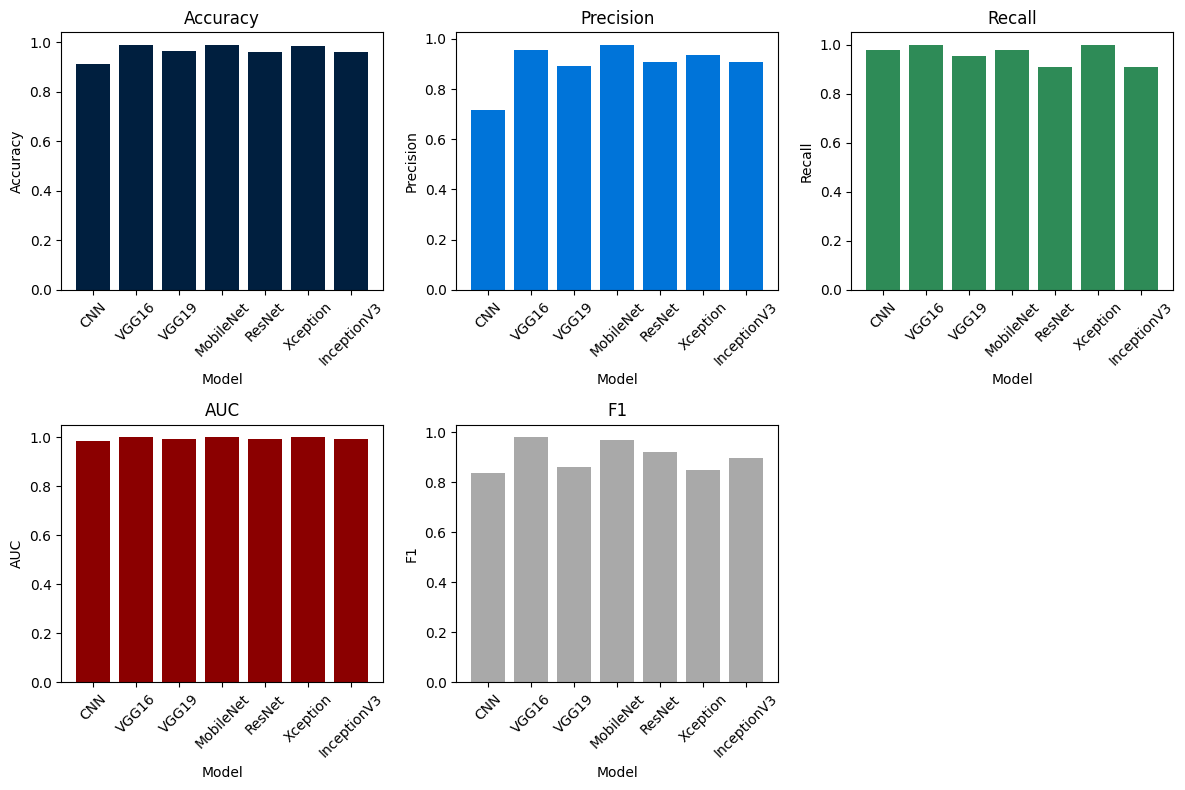

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.ravel()

colors = ['#001f3f', '#0074D9', '#2E8B57', '#8B0000', '#A9A9A9']

for i, column in enumerate(scores.columns):
    axs[i].bar(scores.index, scores[column], color=colors[i])
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel(column)
    axs[i].set_title(f'{column}')
    axs[i].tick_params(axis='x', rotation=45)

for i in range(len(scores.columns), len(axs)):
    plt.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [60]:
eval = np.array(eval)
np.savetxt('eval.txt', eval)

<div style='font-size:100%;'>
    <a id='references'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center> References </center>
    </h1>
</div></center>


1. [1] Tekade, Ruchita, and K. Rajeswari. "Lung cancer detection and classification using deep learning." 2018 Fourth International Conference on Computing Communication Control and Automation (ICCUBEA). IEEE, 2018.
2. [2] Bhatia, Siddharth, Yash Sinha, and Lavika Goel. "Lung cancer detection: a deep learning approach." Soft Computing for Problem Solving. Springer, Singapore, 2019. 699-705.
3. [3] Radhika, P. R., Rakhi AS Nair, and G. Veena. "A comparative study of lung cancer detection using machine learning algorithms." 2019 IEEE International Conference on Electrical, Computer and Communication Technologies (ICECCT). IEEE, 2019.
4. [4] Shakeel, P. Mohamed, Mohd Aboobaider Burhanuddin, and Mohamad Ishak Desa. "Lung cancer detection from CT image using improved profuse clustering and deep learning instantaneously trained neural networks." Measurement 145 (2019): 702-712.
5. [5] Asuntha, A., and Andy Srinivasan. "Deep learning for lung Cancer detection and classification." Multimedia Tools and Applications 79.11 (2020): 7731-7762.
6. [6] Joshua, Eali Stephen Neal, Midhun Chakkravarthy, and Debnath Bhattacharyya. "An Extensive Review on Lung Cancer Detection Using Machine Learning Techniques: A Systematic Study." Rev. d'Intelligence Artif. 34.3 (2020): 351-359.
7. [7] Alsinglawi, Belal, et al. "An explainable machine learning framework for lung cancer hospital length of stay prediction." Scientific reports 12.1 (2022): 1-10.
8. [8] Yan, Sha, et al. "Computed Tomography Images under Deep Learning Algorithm in the Diagnosis of Perioperative Rehabilitation Nursing for Patients with Lung Cancer." Scientific Programming 2022 (2022).
9. [9] Elnakib, Ahmed, Hanan M. Amer, and Fatma EZ Abou-Chadi. "Early lung cancer detection using deep learning optimization." (2020): 82-94.
10. [10] Shimazaki, Akitoshi, et al. "Deep learning-based algorithm for lung cancer detection on chest radiographs using the segmentation method." Scientific reports 12.1 (2022): 1-10.
11. [11] Hosseini, Hesamoddin, Reza Monsefi, and Shabnam Shadroo. "Deep Learning Applications for Lung Cancer Diagnosis: A systematic review." arXiv preprint arXiv:2201.00227 (2022).
12. [12] Li, Wenzhe, et al. "Machine Learning-Assisted Dual-Marker Detection in Serum Small Extracellular Vesicles for the Diagnosis and Prognosis Prediction of Non-Small Cell Lung Cancer." Nanomaterials 12.5 (2022): 809.